### Μέλη Ομάδας:
Ον/μο1:  Φώτιος Κωνσταντίνος Περίχαρος
Αρ. Μητρώου 1:  03117047

Ον/μο2:  Μαρία Ελευθερία Βλόντζου
Αρ. Μητρώου 2:  03117020

# Εργαστηριακή Άσκηση 2. Μη επιβλεπόμενη μάθηση. 
## Σύστημα συστάσεων βασισμένο στο περιεχόμενο
## Σημασιολογική απεικόνιση δεδομένων με χρήση SOM 
Ημερομηνία εκφώνησης της άσκησης: 23 Νοεμβρίου 2021

**Θα βρείτε το παρόν σε μορφή jupyter notebook ως συνημμένο στο τέλος της εκφώνησης.**


In [ ]:
!pip install --upgrade pip
!pip install  numpy
!pip install --upgrade pandas
!pip install --upgrade nltk
!pip install --upgrade scikit-learn
!pip install --upgrade joblib

## Εισαγωγή του Dataset

Το σύνολο δεδομένων με το οποίο θα δουλέψουμε είναι βασισμένο στο [Carnegie Mellon Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/). Πρόκειται για ένα dataset με 22.301 περιγραφές ταινιών. Η περιγραφή κάθε ταινίας αποτελείται από τον τίτλο της, μια ή περισσότερες ετικέτες που χαρακτηρίζουν το είδος της ταινίας και τέλος τη σύνοψη της υπόθεσής της. Αρχικά εισάγουμε το dataset (χρησιμοποιήστε αυτούσιο τον κώδικα, δεν χρειάζεστε το αρχείο csv) στο dataframe `df_data_1`: 

In [ ]:
import pandas as pd

dataset_url = "https://drive.google.com/uc?export=download&id=1-tN5rC1QCgwqL67cvIXdMbtd-Xf9Xqow"
df_data_1 = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3)

Κάθε ομάδα θα δουλέψει σε **ένα μοναδικό υποσύνολο 5.000 ταινιών** (διαφορετικό dataset για κάθε ομάδα) ως εξής:

1. Κάθε ομάδα του εργαστηρίου νευρωνικών έχει έναν αριθμό στο helios. Θα βάλετε τον αριθμό αυτό στη μεταβλητή team_seed_number στο επόμενο κελί κώδικα.

2. Το data frame `df_data_2` έχει γραμμές όσες και οι ομάδες και 5.000 στήλες. Σε κάθε ομάδα αντιστοιχεί η γραμμή του πίνακα με το `team_seed_number` της. Η γραμμή αυτή θα περιλαμβάνει 5.000 διαφορετικούς αριθμούς που αντιστοιχούν σε ταινίες του αρχικού dataset. 

3. Τρέξτε τον κώδικα. Θα προκύψουν τα μοναδικά για κάθε ομάδα  titles, categories, catbins, summaries και corpus με τα οποία θα δουλέψετε.

In [ ]:
import numpy as np

# Στο επόμενη γραμή βάλτε τον αριθμό της ομάδας στο εργαστήριο των νευρωνικών
team_seed_number = 5

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1-oeMf7BFmiH70XObgC9WOTo-a9cDJZwP"
df_data_2 = pd.read_csv(movie_seeds_url, header=None)

# επιλέγεται 
my_index = df_data_2.iloc[team_seed_number,:].values

titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(float)[my_index] # movie categories in binary form (1 feature per category)
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries
corpus_df = pd.DataFrame(corpus) # dataframe version of corpus

- Ο πίνακας **titles** περιέχει τους τίτλους των ταινιών. Παράδειγμα: 'Sid and Nancy'.
- O πίνακας **categories** περιέχει τις κατηγορίες (είδη) της ταινίας υπό τη μορφή string. Παράδειγμα: '"Tragedy",  "Indie",  "Punk rock",  "Addiction Drama",  "Cult",  "Musical",  "Drama",  "Biopic \[feature\]",  "Romantic drama",  "Romance Film",  "Biographical film"'. Παρατηρούμε ότι είναι μια comma separated λίστα strings, με κάθε string να είναι μια κατηγορία.
- Ο πίνακας **catbins** περιλαμβάνει πάλι τις κατηγορίες των ταινιών αλλά σε δυαδική μορφή ([one hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)). Έχει διαστάσεις 5.000 x 322 (όσες οι διαφορετικές κατηγορίες). Αν η ταινία ανήκει στο συγκεκριμένο είδος η αντίστοιχη στήλη παίρνει την τιμή 1, αλλιώς παίρνει την τιμή 0.
- Ο πίνακας **summaries** και η λίστα **corpus** περιλαμβάνουν τις συνόψεις των ταινιών (η corpus είναι απλά ο summaries σε μορφή λίστας). Κάθε σύνοψη είναι ένα (συνήθως μεγάλο) string. Παράδειγμα: *'The film is based on the real story of a Soviet Internal Troops soldier who killed his entire unit  as a result of Dedovschina. The plot unfolds mostly on board of the prisoner transport rail car guarded by a unit of paramilitary conscripts.'*
- το dataframe corpus_df που είναι απλά το corpus σε μορφή dataframe. Τα summaries βρίσκονται στην κολόνα 0. Πιθανώς να σας βολεύει να κάνετε κάποιες προεπεξεργασίες με dataframes.


Θεωρούμε ως **ID** της κάθε ταινίας τον αριθμό γραμμής της ή το αντίστοιχο στοιχείο της λίστας. Παράδειγμα: για να τυπώσουμε τη σύνοψη της ταινίας με `ID=999` (την χιλιοστή) θα γράψουμε `print(corpus[999])`.

In [ ]:
ID = 999
print(titles[ID])
print(categories[ID])
print(catbins[ID])
print(corpus[ID])

['Ang Tanging Pamilya: A Marry Go Round']
['"Comedy",  "Filipino Movies"']
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

# Εφαρμογή 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο
<img src="http://clture.org/wp-content/uploads/2015/12/Netflix-Streaming-End-of-Year-Posts.jpg" width="70%">

Η πρώτη εφαρμογή που θα αναπτύξετε θα είναι ένα [σύστημα συστάσεων](https://en.wikipedia.org/wiki/Recommender_system) ταινιών βασισμένο στο περιεχόμενο (content based recommender system). Τα συστήματα συστάσεων στοχεύουν στο να προτείνουν αυτόματα στο χρήστη αντικείμενα από μια συλλογή τα οποία ιδανικά θέλουμε να βρει ενδιαφέροντα ο χρήστης. Η κατηγοριοποίηση των συστημάτων συστάσεων βασίζεται στο πώς γίνεται η επιλογή (filtering) των συστηνόμενων αντικειμένων. Οι δύο κύριες κατηγορίες είναι η συνεργατική διήθηση (collaborative filtering) όπου το σύστημα προτείνει στο χρήστη αντικείμενα που έχουν αξιολογηθεί θετικά από χρήστες που έχουν παρόμοιο με αυτόν ιστορικό αξιολογήσεων και η διήθηση με βάση το περιεχόμενο (content based filtering), όπου προτείνονται στο χρήστη αντικείμενα με παρόμοιο περιεχόμενο (με βάση κάποια χαρακτηριστικά) με αυτά που έχει προηγουμένως αξιολογήσει θετικά.

Το σύστημα συστάσεων που θα αναπτύξετε θα βασίζεται στο **περιεχόμενο** και συγκεκριμένα στις συνόψεις των ταινιών (corpus). 


## Προεπεξεργασία

Το πρώτο βήμα στην επεξεργασία μας είναι ο καθαρισμός των περιγραφών των ταινιών. 

Εκτυπώστε (αρκετές) διαφορετικές περιγραφές ταινιών για να δείτε πιθανά προβλήματα που θα πρέπει να αντιμετωπιστούν.

Τα (ελάχιστα) βήματα καθαρισμού που προτείνουμε είναι:
- μετατροπή όλων των χαρακτήρων σε πεζά,
- αφαίρεση των stopwords. Εδώ σημειώστε ότι για το δεδομένο task του συστήματος συστάσεων που είναι η πρόταση ταινιών ίσως θα είχαν ενδιαφέρον και λίστες stopwords πέραν αυτών της κοινής γλώσσας.
- αφαίρεση σημείων στίξης και ειδικών χαρακτρήρων (special characters). Αυτό δεν γίνεται μόνο με την punkt του NLTK. Θα μπορούσατε να βασιστείτε σε κανονικές εκφράσεις (regular expressions), και
- αφαίρεση πολυ σύντομων συμβολοσειρών.

Προσοχή: το corpus και τα τελικά tokens που θα το αποτελούν θα χρησιμοποιηθούν στη συνέχεια ως κλειδιά για να βρούμε εμφυτεύματα. Για το λόγο αυτό, πρέπει να είστε προσεκτικοί ως προς την εφαρμογή μεθόδων κανονικοποίησης (text normalization) όπως το stemming και το lemmatization.

In [ ]:
corpus_original=corpus.copy()

In [ ]:
print(summaries)

[["Ranger Steve  sits by a campfire, telling a story about the Davis family. John Davis  is flying a water plane over a valley called Sasquatch Valley with his two daughters Khristy and Maggie. Khristy tells Maggie that a Sasquatch means Bigfoot and Maggie wonders if there are any Bigfoot in the valley. Khristy tells her that Bigfoot is a myth. They finally arrive at their new home and there are pine cones all over the house. At the end of the day everything is cleaned up and everyone goes to bed. Maggie hears something in the shed outside. She finds a small bigfoot in the shed. Maggie trips and falls and the small bigfoot runs away. In the morning John, Maggie, and Khristy go to John's new job. They meet Dave  the boss of the plant. A new dam is going to be built in a river that will provide power for the area. Meanwhile, Cletus McNabb and his sidekick Dawg the dog want to catch a bigfoot. That night Maggie goes outside again to look for the bigfoot. She finds him again and chases the

In [ ]:
pip install -U nltk

In [ ]:
#split corpus into words
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
for i in range(len(corpus)):
  corpus[i] = word_tokenize(corpus[i])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
print(corpus[-1])

['Oru', 'Muthassi', 'Katha', 'is', 'a', 'romantic', 'film', 'with', 'Vineeth', 'and', 'Nirosha', 'playing', 'the', 'lead', 'roles', '.', 'Tamil', 'actor', 'Thyagarajan', 'played', 'the', 'important', 'anti-hero', 'character', '.']


In [ ]:
# convert to lower case
for i in range(len(corpus)):
  corpus[i] = [w.lower() for w in corpus[i]]

In [ ]:
print(corpus[-1])

['oru', 'muthassi', 'katha', 'is', 'a', 'romantic', 'film', 'with', 'vineeth', 'and', 'nirosha', 'playing', 'the', 'lead', 'roles', '.', 'tamil', 'actor', 'thyagarajan', 'played', 'the', 'important', 'anti-hero', 'character', '.']


In [ ]:
# remove punctuation from each word
import string
table = str.maketrans('', '', string.punctuation)
for i in range(len(corpus)):
  corpus[i] = [w.translate(table) for w in corpus[i]]

In [ ]:
print(corpus[-1])

['oru', 'muthassi', 'katha', 'is', 'a', 'romantic', 'film', 'with', 'vineeth', 'and', 'nirosha', 'playing', 'the', 'lead', 'roles', '', 'tamil', 'actor', 'thyagarajan', 'played', 'the', 'important', 'antihero', 'character', '']


In [ ]:
# remove all tokens that are not alphabetic
for i in range(len(corpus)):
  corpus[i] = [word for word in corpus[i] if word.isalpha()]

In [ ]:
print(corpus[-1])

['oru', 'muthassi', 'katha', 'is', 'a', 'romantic', 'film', 'with', 'vineeth', 'and', 'nirosha', 'playing', 'the', 'lead', 'roles', 'tamil', 'actor', 'thyagarajan', 'played', 'the', 'important', 'antihero', 'character']


In [ ]:
corpus_temp1 = corpus
corpus_temp2 = corpus

Δοκιμάσαμε τρεις διαφορετικές βιβλιοθήκες με stopwords, την NLTK, την spaCy και την Scikit-Learn. Με πλήθος των λέξεων που απομένουν σε κάθε στοιχείο της λίστας corpus, παρατηρήσαμε πως χρησιμιποιώντας τα stopwords της Scikit-Learn εξαλείφθηκαν περισσότερες λέξεις. Επομένως, επιλέξαμε να κρατήσουμε τη συγκεκριμένη βιβλιοθήκη.

In [ ]:
# filter out stop words
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
for i in range(len(corpus_temp1)):
  corpus_temp1[i] = [w for w in corpus_temp1[i] if not w in stop_words]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
print(len(corpus_temp1[2]))

350


In [ ]:
# filter out stop words
import spacy
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words
for i in range(len(corpus_temp2)):
  corpus_temp2[i] = [w for w in corpus_temp2[i] if not w in sw_spacy]

In [ ]:
print(len(corpus_temp2[2]))

331


In [ ]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
for i in range(len(corpus)):
  corpus[i] = [w for w in corpus[i] if not w in ENGLISH_STOP_WORDS]

In [ ]:
print(len(corpus[2]))

330


In [ ]:
#filter out words with lenght smaller than 3
small_corpus=[]
for i in range(len(corpus)):
  small_corpus.append(list(filter(lambda x: len(x) > 3, corpus[i])))


In [ ]:
print(len(small_corpus[2]))

292


In [ ]:
corpus=small_corpus

In [ ]:
for i in range(len(corpus)):
  corpus[i]=' '.join(corpus[i])

In [ ]:
print(corpus[2])

released rehab days home attend wedding sister rachel home atmosphere strained family members struggle reconcile past present father shows intense concern wellbeing whereabouts interprets mistrust resents sister choice best friend emma maid honor rachel resents attention sister drug addiction drawing away wedding resentment comes head rehearsal dinner amid toasts friends family takes microphone offer apology past actions twelvestep program underlying family dynamic tragedy occurred years previously retells narcotics anonymous meeting teenager responsible death young brother ethan left care driving home nearby park intoxicated lost control driving bridge lake brother drowned wedding rachel bridesmaids getting hair approached knew earlier stint rehab thanks strength gave story molested uncle cared sister anorexic rachel hearing storms story turns mdash apparent attempt evade responsibility addiction sisters fight comes head later night father house comes home turns rachel blames ethan de

## Μετατροπή σε TFIDF

Το πρώτο βήμα θα είναι λοιπόν να μετατρέψετε το corpus σε αναπαράσταση tf-idf:

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# create sparse tf_idf representation
vectorizer = TfidfVectorizer(max_df=0.5, min_df=15, stop_words='english')
vectorizer.fit(corpus)
corpus_tf_idf_plain = vectorizer.transform(corpus).toarray()

Η συνάρτηση [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) όπως καλείται εδώ **δεν είναι βελτιστοποιημένη**. Οι επιλογές των μεθόδων και παραμέτρων της μπορεί να έχουν **δραματική επίδραση στην ποιότητα των συστάσεων** και είναι διαφορετικές για κάθε dataset. Επίσης, οι επιλογές αυτές έχουν πολύ μεγάλη επίδραση και στη **διαστατικότητα και όγκο των δεδομένων**. Η διαστατικότητα των δεδομένων με τη σειρά της θα έχει πολύ μεγάλη επίδραση στους **χρόνους εκπαίδευσης**, ιδιαίτερα στη δεύτερη εφαρμογή της άσκησης.

Προσοχή: ο TfidfVectorizer έχει κάποιες δυνατότητες προεπεξεργασίας παρόποιες με αυτές που αναφέραμε στην προηγούμενη ενότητα. Ό,τι προεπεξεργασία μπορείτε να κάνετε που χρειάζεται ως είσοδο μόνο το κάθε document ξεχωριστά, κάντε την στο πρώτο βήμα της προεπεξεργασίας. Αν χρειάζεται γνώση των συνολικών στατιστικών της συλλογής, κάντε την με τον TfidfVectorizer.

In [ ]:
print(corpus_tf_idf_plain.shape)

(5000, 5641)


## Υλοποίηση του συστήματος συστάσεων

Το σύστημα συστάσεων που θα υλοποιήσετε θα είναι μια συνάρτηση `content_recommender` με τρία ορίσματα: `target_movie`, `max_recommendations` και `corpus_type`. Στην `target_movie` περνάμε το ID μιας ταινίας-στόχου για την οποία μας ενδιαφέρει να βρούμε παρόμοιες ως προς το περιεχόμενο (τη σύνοψη) ταινίες, `max_recommendations` στο πλήθος.
Υλοποιήστε τη συνάρτηση ως εξής: 
- για την ταινία-στόχο, θα υπολογίζετε την [ομοιότητα συνημιτόνου](https://en.wikipedia.org/wiki/Cosine_similarity) της με όλες τις ταινίες της συλλογής σας όπως αυτές αναπαριστώνται στο `corpus_type`.
- με βάση την ομοιότητα συνημιτόνου που υπολογίσατε, δημιουργήστε ταξινομημένο πίνακα από το μεγαλύτερο στο μικρότερο, με τα indices (`ID`) των ταινιών. Παράδειγμα: αν η ταινία με index 1 έχει ομοιότητα συνημιτόνου με 3 ταινίες \[0.2 1 0.6\] (έχει ομοιότητα 1 με τον εαύτό της) ο ταξινομημένος αυτός πίνακας indices θα είναι \[1 2 0\].
- Για την ταινία-στόχο εκτυπώστε: id, τίτλο, σύνοψη, κατηγορίες (categories)
- Για τις `max_recommendations` ταινίες (πλην της ίδιας της ταινίας-στόχου που έχει cosine similarity 1 με τον εαυτό της) με τη μεγαλύτερη ομοιότητα συνημιτόνου (σε φθίνουσα σειρά), τυπώστε σειρά σύστασης (1 πιο κοντινή, 2 η δεύτερη πιο κοντινή κλπ), ομοιότητα συνημιτόνου, id, τίτλο, σύνοψη, και κατηγορίες (categories)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
def content_recommender(target_movie, max_reccomendations, corpus_type):

  cosine_results={}
  
  for i in range(5000):
    if(i != target_movie):
      cosine_results[i] = float(cosine_similarity([corpus_type[target_movie]], [corpus_type[i]]))
      
  sorted_cosine_results = {}
  sorted_keys = sorted(cosine_results, key=cosine_results.get)

  for w in sorted_keys:
    sorted_cosine_results[w] = cosine_results[w]

  cosine_results_sorted = dict(reversed(list(sorted_cosine_results.items())))
  results_list=list(cosine_results_sorted.keys())

  print("Movie id is: ", target_movie)
  print("Movie title is: ", titles[target_movie])
  print("Movie summary is: ", summaries[target_movie])
  print("Movie categories are: ", categories[target_movie])
  print('\n')

  print("Similar movies desctriptions")

  cosines=list(cosine_results_sorted.values())

  for i in range(max_reccomendations):
    print("Similar movie cosine similarity is: ", cosines[i])
    print("Similar movie id is: ", results_list[i])
    print("Similar movie title is: ", titles[results_list[i]])
    print("Similar movie summary is: ", summaries[results_list[i]])
    print("Similar movie categories are: ", categories[results_list[i]])
    print('\n')

  return results_list[0:max_reccomendations]

In [ ]:
print(content_recommender(2, 10, corpus_tf_idf_plain))

Movie id is:  2
Movie title is:  ['Rachel Getting Married']
Movie summary is:  ["Kym  is released from rehab for a few days so she can go home to attend the wedding of her sister Rachel . At home, the atmosphere is strained between Kym and her family members as they struggle to reconcile themselves with her past and present. Kym's father  shows intense concern for her well-being and whereabouts, which Kym interprets as mistrust. She also resents her sister's choice of her best friend Emma , rather than Kym, to be her maid of honor. Rachel, for her part, resents the attention her sister's drug addiction is drawing away from her wedding, a resentment that comes to a head at the rehearsal dinner, where Kym, amid toasts from friends and family, takes the microphone to offer an apology for her past actions, as part of her twelve-step program. Underlying the family's dynamic is a tragedy that occurred years previously, which Kym retells at a Narcotics Anonymous meeting. As a teenager, Kym wa

Στο παραπάνω παράδειγμα, για τις ταινίες που έχουν όμοιο content με την ταινία με id=2, η εμφάνιση του ονόματος "Rachel" στις περιγραφές είναι αυτή που κάνει τον content_recommender να τις θεωρεί similar με τη συγκεκριμένη ταινία στόχο. Επομένως, προκειμένου να βελτιστοποιήσουμε τον TfidfVectorizer, θα πρέπει, όσο είναι εφικτό, να αφαιρέσουμε από τις περιγραφές των ταινιών τα ονόματα.

## Βελτιστοποίηση του TfidfVectorizer

Αφού υλοποιήσετε τη συνάρτηση `content_recommender` χρησιμοποιήστε την για να βελτιστοποιήσετε την `TfidfVectorizer`. Συγκεκριμένα, αρχικά μπορείτε να δείτε τι επιστρέφει το σύστημα για τυχαίες ταινίες-στόχους και για ένα μικρό `max_recommendations` (2 ή 3). Αν σε κάποιες ταινίες το σύστημα μοιάζει να επιστρέφει σημασιολογικά κοντινές ταινίες σημειώστε το `ID` τους. Δοκιμάστε στη συνέχεια να βελτιστοποιήσετε την `TfidfVectorizer` για τα συγκεκριμένα `ID` ώστε να επιστρέφονται σημασιολογικά κοντινές ταινίες για μεγαλύτερο αριθμό `max_recommendations`. Παράλληλα, όσο βελτιστοποιείτε την `TfidfVectorizer`, θα πρέπει να λαμβάνετε καλές συστάσεις για μεγαλύτερο αριθμό τυχαίων ταινιών. 

Ταυτόχρονα, μια αντίρροπη κατά κάποιο τρόπο κατεύθυνση της βελτιστοποίησης είναι να χρησιμοποιείτε τις παραμέτρους του `TfidfVectorizer` έτσι ώστε να μειώνονται οι διαστάσεις του Vector Space Model μέχρι το σημείο που θα αρχίσει να εμφανίζονται επιπτώσεις στην ποιότητα των συστάσεων. 




### Αφαίρεση Ονομάτων & Λέξεων που χρησιμοποιούνται στην αρχή της περιγραφής

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('names')
stop_words1=list(nltk.corpus.names.words())
stop_words2 = list(stopwords.words('english'))
stop_words3 = ['film','movie', 'story', 'opens', 'begins', 'starts', 'started', 'centres', 'plot', 'based', 'about']

stop=stop_words1+stop_words2+stop_words3

stop = [word.lower() for word in stop]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# create sparse tf_idf representation
vectorizer = TfidfVectorizer(max_df=0.5, min_df=15, stop_words=stop)
vectorizer.fit(corpus)
corpus_tf_idf_opt = vectorizer.transform(corpus).toarray()
corpus_tf_idf_opt_csr_matrix = vectorizer.transform(corpus)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  % sorted(inconsistent)


In [ ]:
print(corpus_tf_idf_opt.shape)

(5000, 5282)


Παρατηρούμε πως το μέγεθος ελαττώθηκε, επομένως, αφαιρέθηκαν όλα τα ονόματα και οι λέξεις που προσθέσαμε στα stop_words. Έτσι, για την ίδια ταινία με id=2, δεν επιστρέφονται πλέον από τον content_recommender ταινίες με το όνομα "Rachel", αλλά ταινίες με παρόμοια summaries σχετικά με "marriage" και "wedding".

In [ ]:
print(content_recommender(2, 10, corpus_tf_idf_opt))

Movie id is:  2
Movie title is:  ['Rachel Getting Married']
Movie summary is:  ["Kym  is released from rehab for a few days so she can go home to attend the wedding of her sister Rachel . At home, the atmosphere is strained between Kym and her family members as they struggle to reconcile themselves with her past and present. Kym's father  shows intense concern for her well-being and whereabouts, which Kym interprets as mistrust. She also resents her sister's choice of her best friend Emma , rather than Kym, to be her maid of honor. Rachel, for her part, resents the attention her sister's drug addiction is drawing away from her wedding, a resentment that comes to a head at the rehearsal dinner, where Kym, amid toasts from friends and family, takes the microphone to offer an apology for her past actions, as part of her twelve-step program. Underlying the family's dynamic is a tragedy that occurred years previously, which Kym retells at a Narcotics Anonymous meeting. As a teenager, Kym wa

#### Παράδειγμα ταινιών που έχουν content σχετικό με μυστήριο και έγκλημα.

In [ ]:
print(content_recommender(567, 3, corpus_tf_idf_opt))

Movie id is:  567
Movie title is:  ['The Rings']
Movie summary is:  ["The citizens of an unnamed city are being terrorized by an extraordinary killer. The victims pick up a ringing phone and are told by a mysterious voice how long they have to live. Invariably, they all die in mysterious ways at the exact specified moment. A reporter begins to investigate the phenomenon, but the more he investigates the deaths the more mysterious they seem. As he delves into more cases he becomes personally involved and obsessed. Before long, he finds his family and finally himself targets of the elusive killer. The film ends with the reporter's death. The nature of who or what  caused the deaths is not resolved in the end, and the audience is left to decide on the film's narrative."]
Movie categories are:  ['"Mystery",  "Horror"']


Similar movies desctriptions
Similar movie cosine similarity is:  0.27231365919808487
Similar movie id is:  3141
Similar movie title is:  ['A Show of Force']
Similar movie

#### Παράδειγμα ταινιών που έχουν content σχετικό με τη σκηνοθεσία και το θέατρο.

In [ ]:
print(content_recommender(3456, 3, corpus_tf_idf_opt))

Movie id is:  3456
Movie title is:  ['Cosi']
Movie summary is:  ["Ben Mendelsohn stars as Lewis Riley, an unemployed young man who applies for a job as a director/drama teacher at a mental hospital. He lands the job and finds himself directing a production of the Mozart opera Cosi Fan Tutte. That's an elaborate, demanding piece of theatre. And it's an opera. And it's in Italian. And it's going to be performed by a cast that he must select from among the patients, who only speak English. One of the patients, Roy , sweeps everything along before him, organising auditions, selecting cast members, and criticising the director. The cast chosen include three women: Julie , Ruth , and Cherry ; and two men: Henry  and Doug . The musical director is Zac . The enthusiasm of Roy infects the group, and they charge headlong into a memorable production. Alongside the story of Lewis, the theme of Cosi Fan Tutte is explored as it relates to his personal life. Lewis's relationship with his girlfriend L

#### Παράδειγμα ταινιών που έχουν content σχετικό με τους εξωγήινους.

In [ ]:
print(content_recommender(2496, 3, corpus_tf_idf_opt))

Movie id is:  2496
Movie title is:  ['Alien: Resurrection']
Movie summary is:  ["Two hundred years after the events of Alien 3, military scientists on the outer space vessel USM Auriga create a clone of Ellen Ripley , using DNA from blood samples taken before her death. They extract the embryo of an Alien queen that had been growing inside her at the time of her death, raise it, and collect its eggs for further use. The Ripley clone is kept alive for further study. As a result of her DNA being mixed with the Alien's during the cloning process, she develops enhanced strength and reflexes, acidic blood, and an empathic link with the Aliens. A group of mercenaries arrive in their ship, the Betty, delivering several kidnapped humans in stasis. The military scientists use the kidnapped humans as hosts for the Aliens, raising several adult Aliens for study. The Betty crew soon encounter Ripley. Call  recognizes her name and tries to kill her, believing she may be used to create more Aliens. 

### Δοκιμή διαφορετικών παραμέτρων του TfidfVectorizer

#### Ελάττωση του min_df

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# create sparse tf_idf representation
vectorizer1 = TfidfVectorizer(max_df=0.5, min_df=5, stop_words=stop)
vectorizer1.fit(corpus)
corpus_tf_idf_opt1 = vectorizer1.transform(corpus).toarray()

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  % sorted(inconsistent)


In [ ]:
print(content_recommender(2, 3, corpus_tf_idf_opt1))

Movie id is:  2
Movie title is:  ['Rachel Getting Married']
Movie summary is:  ["Kym  is released from rehab for a few days so she can go home to attend the wedding of her sister Rachel . At home, the atmosphere is strained between Kym and her family members as they struggle to reconcile themselves with her past and present. Kym's father  shows intense concern for her well-being and whereabouts, which Kym interprets as mistrust. She also resents her sister's choice of her best friend Emma , rather than Kym, to be her maid of honor. Rachel, for her part, resents the attention her sister's drug addiction is drawing away from her wedding, a resentment that comes to a head at the rehearsal dinner, where Kym, amid toasts from friends and family, takes the microphone to offer an apology for her past actions, as part of her twelve-step program. Underlying the family's dynamic is a tragedy that occurred years previously, which Kym retells at a Narcotics Anonymous meeting. As a teenager, Kym wa

Παρατηρούμε πως για την ίδια ταινία που προηγουμένως εμφανίζονταν όμοιες ταινίες σχετικές με τον γάμο, έχοντας ελαττώσει το min_df δεν λαμβάνουμε τόσο καλά αποτελέσματα όσο πριν.

#### Ελάττωση του max_df

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# create sparse tf_idf representation
vectorizer2 = TfidfVectorizer(max_df=0.2, min_df=15, stop_words=stop)
vectorizer2.fit(corpus)
corpus_tf_idf_opt2 = vectorizer2.transform(corpus).toarray()

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  % sorted(inconsistent)


In [ ]:
print(content_recommender(2, 10, corpus_tf_idf_opt2))

Movie id is:  2
Movie title is:  ['Rachel Getting Married']
Movie summary is:  ["Kym  is released from rehab for a few days so she can go home to attend the wedding of her sister Rachel . At home, the atmosphere is strained between Kym and her family members as they struggle to reconcile themselves with her past and present. Kym's father  shows intense concern for her well-being and whereabouts, which Kym interprets as mistrust. She also resents her sister's choice of her best friend Emma , rather than Kym, to be her maid of honor. Rachel, for her part, resents the attention her sister's drug addiction is drawing away from her wedding, a resentment that comes to a head at the rehearsal dinner, where Kym, amid toasts from friends and family, takes the microphone to offer an apology for her past actions, as part of her twelve-step program. Underlying the family's dynamic is a tragedy that occurred years previously, which Kym retells at a Narcotics Anonymous meeting. As a teenager, Kym wa

Παρατηρήσαμε πως η επίδραση της αλλαγής του max_df στο cosine similarity δεν ήταν τόσο σημαντική όσο αυτή της αλλαγής του min_df. Συγκρίνοντας τα αποτελέσματα του recommender με corpus_tf_idf_opt που είχε max_df=0.5 και με corpus_tf_idf_opt2 που είχε max_df=0.2 παρατηρούμε πως είναι αρκετά παρόμοια. Ωστόσο, τα αποτελέσματα, ενώ τα περισσότερα ήταν κοινά, αλλά με διαφορετική σειρά, είχαν μικρότερο cosine similarity.

## Βαθιά μάθηση: δημιουργία corpora με χρήση word emmbeddings

Η προσέγγιση της κατασκευής μόνο μέσω tfidf του συστήματος συστάσεων έχει διάφορα μειονεκτήματα. Θα μας ενδιέφερε λοιπόν να δούμε αν μπορούμε να χρησιμοποιήσουμε για τις λέξεις **εμφυτεύματα (embeddings)**, δηλαδή τις πυκνές διανυσματικές αναπαραστάσεις για τις λέξεις που μας δίνει το μοντέλο **Word2Vec**

Ωστόσο, το dataset της κάθε ομάδας είναι πολύ μικρό για να εξάγουμε τα δικά μας word embeddings (και να είναι καλά). Για το λόγο αυτό θα χρησιμοποιήσουμε τη μεθοδολογία της Βαθιάς Μάθησης που είναι η **Μεταφορά Μάθησης (Transfer Learning).**.

Στη μεταφορά μάθησης ουσιαστικά μεταφέρουμε τη γνώση που έχει αποκτήσει ένα ήδη εκπαιδευμένο (και κατά κανόνα πολύ μεγάλο) σύστημα. Η μεταφορά γίνεται διαμέσου των τιμών των βαρών που έχει προσδιορίσει μετά το πέρας της εκπαίδευσης.

Στην περίπτωσή μας, δεν μας ενδιαφέρουν τόσο τα ίδια τα βάρη των μοντέλων από τα οποία θα κάνουμε μεταφορά μάθησης. Κάτι τέτοιο θα μας ενδιέφερε αν π.χ. θέλαμε να συνεχίσουμε την εκπαίδευση στα δικά μας κείμενα. Μας ενδιαφέρουν όμως τα ίδια τα εμφυτεύματα, δηλαδή τα embeddings (διανύσματα διαστάσεων $m$) που έχει μάθει το νευρωνικό για το λεξιλόγιο του (vocabulary). To vocabulary σε τέτοια μεγάλα νευρωνικά θα είναι πιθανότατα υπερσύνολο του δικού μας.

### Μεταφορά μάθησης εμφυτευμάτων



#### Εμφυτεύματα του Gensim-data
Το Gensim περιλαμβάνει αρκετά προεκπαιδευμένα μοντέλα εμφυτευμάτων Word2Vec. Με το επόμενο κελί παίρνουμε τη λίστα τους.

In [ ]:
!pip install -U gensim
import gensim.downloader
print(list(gensim.downloader.info()['models'].keys()))

     |████████████████████████████████| 24.1 MB 1.3 MB/s            
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
from gensim.models import Word2Vec
gensim.downloader.load

<function gensim.downloader.load>

In [ ]:
import gensim.downloader as api

In [ ]:
import gensim.downloader as api
model_gigaword = api.load("glove-wiki-gigaword-50")

[==================================================] 100.0% 66.0/66.0MB downloaded


In [ ]:
model_twitter=api.load("glove-twitter-50")

In [ ]:
model_gigaword_300 = api.load("glove-wiki-gigaword-300")

[==================================================] 100.0% 376.1/376.1MB downloaded


Τα μοντέλα αυτά βρίσκονται στο [αποθετήριο Gensim-data](https://github.com/RaRe-Technologies/gensim-data) όπου μπορείτε να βρείτε και την τεκμηρίωσή τους. Η φόρτωση των μοντέλων αυτών γίνεται με τη συνάρτηση `gensim.downloader.load`.

#### Άλλα εμφυτεύμαατα
Μπορείτε να βρείτε προεκπαιδευμένα εμφυτεύματα και από πηγές εκτός του Gensim. Για παράδειγμα:

- [Google News dataset](https://code.google.com/archive/p/word2vec/). Πρόκειται για προ-εκπαιδευμένα διανύσματα που έχουν εκπαιδευτεί σε μέρος του συνόλου δεδομένων Google News (περίπου 100 δισεκατομμύρια λέξεις). Το μοντέλο περιέχει διανύσματα 300 διαστάσεων για 3 εκατομμύρια λέξεις και φράσεις.
- [Amazon BlazingText](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html). Το BlazingText δεν είναι μόνο προεκπαιδευμένα εμφυτεύματα αλλα και βελτιστοποιημένες υλοποιήσεις των αλγορίθμων Word2vec για την επεξεργασία κειμένου. Προυπόθεση είναι να δουλέψει κανείς στο SageMaker.

Οι διαδικασίες φόρτωσης embeddings από εξωτερικά δεδομένα μπορεί να είναι ελαφρά διαφορετικές από αυτή του Gensim.



#### Παρατηρήσεις

*   Επαναλαμβάνουμε ότι στην εργασία αυτή δεν μας ενδιαφέρουν τα ίδια τα μοντέλα αλλά το να μπορούμε για μία λέξη του λεξιλογίου μας να μπορούμε να βρούμε το embedding (διάνυσμα) που της αντιστοιχεί στο εκάστοτε προεκπαιδευμένο μοντέλο. 

*   Επίσης, δεν θα χρησιμοποιήσουμε την `Phrases` για να βρούμε bigrams στο dataset μας όπως θα ήταν το ορθότερο, καθώς αυτό θα απαιτούσε την συνέχιση της εκπαίδευσης του μοντέλου σε νέο λεξιλόγιο με πολύ λίγα νέα δεδομένα.


 ### Δημιουργία corpora βασισμένων στα εμφυτεύματα

Για να μπορέσουμε να ενσωματώσουμε τη γνώση που υπάρχει στα προεκπαιδευμένα εμφυτεύματα στο δικό μας corpus θα προχωρήσουμε όπως περιγράφεται ακολούθως.

Για κάθε περιγραφή ταινίας $d$, η οποία αποτελείται από τις $N_d$ λέξεις $w_i$, το  $tfidf$ της κάθε λέξης $w_i$ δίνεται από τη σχέση:

$$ tfidf(w_i) = tf(w_i,d) \cdot idf(w_i)$$

Ταυτόχρονα, σε κάθε λέξη $w_i$ αντιστοιχεί ένα διάνυσμα $W2V(w_i)$ από το μοντέλο εμφυτευμάτων που έχουμε εισάγει. Τα διανύσματα εμφυτευμάτων $W2V$ θα έχουν διάσταση $m$, ανάλογα το μοντέλο. 

Για κάθε ταινία d, μπορούμε να δημιουργήσουμε μια διανυσματική αναπαράσταση $W2V(d)$ διαστάσεων $m$ χρησιμοποιώντας το $tfidf(w_i)$ ως συντελεστή βαρύτητας για κάθε εμφύτευμα $W2V(w_i)$:

$$ W2V(d) = \frac{tfidf(w_1)\cdot W2V(w_i) + tfidf(w_2)\cdot W2V(w_2) + \dotsc  + tfidf(w_{N_{d}})\cdot W2V(w_{N_{d}})}{tfidf(w_1)+tfidf(w_2)+ \dotsc + tfidf(w_{N_{d}})}$$


####Preprocessing

In [ ]:
corpus_unprocessed=corpus_original.copy()

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('names')
stop_words1=list(nltk.corpus.names.words())
stop_words2 = list(stopwords.words('english'))
stop_words3 = ['film','movie', 'story', 'opens', 'begins', 'starts', 'started', 'centres', 'plot', 'based', 'about']

stop=stop_words1+stop_words2+stop_words3

stop = [word.lower() for word in stop]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!


In [ ]:
small_corpus=[]
for i in range(len(corpus_unprocessed)):
  corpus_unprocessed[i] = word_tokenize(corpus_unprocessed[i]) #split corpus into words
  corpus_unprocessed[i] = [w.lower() for w in corpus_unprocessed[i]] #convert to lower case
  corpus_unprocessed[i] = [w.translate(table) for w in corpus_unprocessed[i]] # remove punctuation from each word
  corpus_unprocessed[i] = [word for word in corpus_unprocessed[i] if word.isalpha()]   # remove all tokens that are not alphabetic
  corpus_unprocessed[i] = [w for w in corpus_unprocessed[i] if not w in stop] #filter out stopwords
  small_corpus.append(list(filter(lambda x: len(x) > 3, corpus_unprocessed[i]))) # filter out words with length < 3 
  
corpus_processed=small_corpus

for i in range(len(corpus_processed)):
  corpus_processed[i]=' '.join(corpus_processed[i])


In [ ]:
print(corpus_processed[2])

In [ ]:
tfidf = TfidfVectorizer(max_df=0.2, min_df=15, stop_words=stop)
tfidf.fit_transform(corpus_processed)

# Getting the words from the TF-IDF model

tfidf_list = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))
tfidf_feature = tfidf.get_feature_names() # tfidf words/col-names

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'zsa'] not in stop_words.
  % sorted(inconsistent)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


#### build_tfw2v

Υλοποιήστε μια συνάρτηση `build_tfw2v` με ορίσματα:
- `corpus` που θα είναι το προεπεξεργασμένο dataset σας,
- `vectors` που θα είναι το μοντέλο που θα σας δίνει τα διανύσματα των εμφυτεύσεων vectors, και 
- `embeddings_size` που θα είναι η διάσταση των εμφυτευμάτων $m$.

H συνάρτηση αυτή θα επιστρέφει ένα νέο corpus που θα είναι ένας πίνακας 5000 (όσες οι ταινίες σας) x $m$ (το η διάσταση των εμφυτευμάτων). Ανάλογα ποιο μοντέλο χρησιμποιείτε για transfer learning ο πίνακας αυτός θα είναι διαφορετικός.

Μπορείτε πλεόν να καλείτε την `content_recommender` με διαφορετικά corpora στο όρισμα `corpus_type`. Σημειώστε ότι στο TFidfVectorizer χρησιμοποιουμε τη σειριακή μορφή των numpy arrays και ίσως σας χρησιμεύσει η `sparse.csr_matrix()` από την Scipy.

In [ ]:
from scipy import sparse

In [ ]:
def build_tfw2v(corpus, vectors, embeddings_size):

  tfidf_vectors = []; 
  # for each book description
  for desc in corpus:
    # Word vectors are of zero length 
    sent_vec = np.zeros(embeddings_size) 
    # num of words with a valid vector in the movie summary
    weight_sum =0; 
    # for each word in the movie summary
    #split string
    splits = desc.split()
    
    for split in splits:
      if split in vectors.index_to_key and split in tfidf_feature:
        vec = vectors[split]
        tf_idf = tfidf_list[split] * (desc.count(split) / len(desc))
        sent_vec += (vec * tf_idf)
        weight_sum += tf_idf
    if weight_sum != 0:
      sent_vec /= weight_sum
    tfidf_vectors.append(sent_vec)

  return(tfidf_vectors) 

In [ ]:
vectors_gigaword_50=sparse.csr_matrix(build_tfw2v(corpus_processed, model_gigaword, 50),shape=(5000,5000)).toarray()

In [ ]:
vectors_twitter_50=sparse.csr_matrix(build_tfw2v(corpus, model_twitter, 50),shape=(5000,5000)).toarray()

In [ ]:
vectors_gigaword_300=sparse.csr_matrix(build_tfw2v(corpus_processed, model_gigaword_300, 300),shape=(5000,5000)).toarray()

## Ανάλυση αποτελεσμάτων

### Σύστημα συστάσεων βασισμένο μόνο στο tfidf

- Σε markdown περιγράψτε τι προεπεξεργασία κάνετε στα κείμενα και γιατί.

- Περιγράψτε πως προχωρήσατε στις επιλογές σας για τη βελτιστοποίηση της `TfidfVectorizer`. 

- [Cherry-picking:](https://www.wikiwand.com/en/Cherry_picking) Δώσετε παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν καλά αποτελέσματα μέχρι `max_recommendations` (τουλάχιστον 5) και σχολιάστε.

- [Nir-picking:](https://www.merriam-webster.com/dictionary/nit-picking) Δώστε παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν κακά αποτελέσματα και σχολιάστε.

- Ποια είναι συνολικά τα πλεονεκτήματα και μειονεκτήματα ενός recommender βασισμένου στο tfidf;

#### Προεπεξεργασία:

Η προεπεξεργασία που έγινε στα κείμενα ήταν: 
* Ο χωρισμός των προτάσεων του corpus σε λέξεις (με τη χρήση του word_tokenizer που πραγματοποιεί διαχωρισμό με βάση τα κενά, τα tabs και τα new lines και διαχωρισμό των παρενθέσεων από το περιεχόμενό τους), ώστε στη συνέχεια να πραγματοποιηθεί επεξεργασία σε κάθε λέξη ξεχωριστά.
* Η μετατροπή όλων των κεφαλαίων χαρακτήρων σε πεζούς, ώστε ίδιες λέξεις, με μόνη διαφορά πεζούς ή κεφαλαίους χαρακτήρες, να μην θεωρούνται διαφορετικές.
* Αφαίρεση των σημείων στίξης, τόσο αυτών που εμφανίζονται ως ξεχωριστές λέξεις, όσο και αυτών που βρίσκονται ανάμεσα στους χαρακτήρες μίας λέξης.
* Αφαίρεση όλων των χαρακτήρων που δεν είναι αλφαριθμητικοί.
* Αφαίρεση stopwords. Τα stopwords που επιλέξαμε ήταν η συλλογή english από τη βιβλιοθήκη NLTK, η συλλογή names από την ίδια βιβλιοθήκη, καθώς και ορισμένες λέξεις που συναντήσαμε πολύ συχνά στις περιγραφές των ταινιών και οι οποίες ήταν μέρος εκφράσεων που δεν προσέδιδαν πληροφορία σχετικά με το περιεχόμενο της ταινίας. Ο λόγος που έγιναν οι συγκεκριμένες επιλογές ήταν: Η αφαίρεση των λέξεων της συλλοής english και των λέξεων που χρησιμοποιούνται στην αρχή της περιγραφής των ταινιών, έγινε προκειμένου να παραλειφθούν κάποιες λέξεις που εμφανίζονται πολύ συχνά στον λόγο και δεν προσφέρουν σημαντική πληροφορία στο κείμενο. Η αφαίρεση των ονομάτων έγινε, καθώς παρατηρήθηκε πως σε ορισμένες ταινίες που εμφανιζόταν κάποιο συγκεκριμένο όνομα, δίνονταν ως similar ταινίες αυτές που είχαν στην περιγραφή τους το ίδιο όνομα. Για παράδειγμα σε ταινία με έναν χαρακτήρα που είχε όνομα Rachel, δίνονταν ως similar ταινίες, πολλές που είχαν χαρακτήρες με το ίδιο όνομα. Αφαιρώντας, λοιπόν, και τα ονόματα, πλεόν αποφεύγονταν τέτοια φαινόμενα.
* Τέλος, πραγματοποιήθηκε αφαίρεση των λέξεων με μήκος μικρότερο από 3

#### Βελτιστοποίηση του TfidifVectorizer:

Μεγάλο μέρος της βελτιστοποίησης του Tfidf αποτέλεσε η προσθήκη επιπλεόν stop_words και συγκεκριμένα των ονομάτων. Επιπλέον, δοκιμάστηκαν διάφορες τιμές για τις παραμέτρους min_df και max_df και διατηρήθηκαν εκείνες που έκαναν τον recommender να επιστρέφει το μέγιστο cosine similarity για κάθε συγκεκριμένο μοντέλο. Επομένως, οι τιμές που χρησιμοποιούνται για τις παραμέτρους αυτές είναι max_df=0.5, όπου αγνοούνται όλοι οι όροι που εμφανίζονται σε πάνω από 50% των περιγραφών και min_df=15, όπου αγνοούνται οι όροι που εμφανίζονται σε περισσότερες από 15 περιγραφές.

#### Παραδείγματα καλών αποτελεσμάτων:

##### Παράδειγμα ταινιών που έχουν θέμα σχετικό με εξωγήινους

Όλες οι ταινίες που επιστρέφει ο recommender σ' αυτό το παράδειγμα είναι σχετικές με την ταινία στόχο και μάλιστα επιστρέφεται και η ταινία Alien3 που αποτελεί prequel της συγκεκριμένης.

In [ ]:
print(content_recommender(2496, 8, corpus_tf_idf_opt))

Movie id is:  2496
Movie title is:  ['Alien: Resurrection']
Movie summary is:  ["Two hundred years after the events of Alien 3, military scientists on the outer space vessel USM Auriga create a clone of Ellen Ripley , using DNA from blood samples taken before her death. They extract the embryo of an Alien queen that had been growing inside her at the time of her death, raise it, and collect its eggs for further use. The Ripley clone is kept alive for further study. As a result of her DNA being mixed with the Alien's during the cloning process, she develops enhanced strength and reflexes, acidic blood, and an empathic link with the Aliens. A group of mercenaries arrive in their ship, the Betty, delivering several kidnapped humans in stasis. The military scientists use the kidnapped humans as hosts for the Aliens, raising several adult Aliens for study. The Betty crew soon encounter Ripley. Call  recognizes her name and tries to kill her, believing she may be used to create more Aliens. 

##### Παράδειγμα ταινιών που έχουν θέμα σχετικό με το διάστημα και αποτελούν ταινίες επιστημονικής φαντασίας

In [ ]:
print(content_recommender(1847, 6, corpus_tf_idf_opt))

Movie id is:  1847
Movie title is:  ['Man Conquers Space']
Movie summary is:  ["The dawn of the Space Age is amidst the crucible of World War II. Prompted by gaining pre-eminence in the high-ground of space, the world's triumphant superpowers race to dominate orbit, the Moon and beyond. To this end, the United States government under President Truman commits to founding the National Council of Astronautics  and the United States Space Force  in 1949. After a period of technological development and installation of infrastructure, Eagle One lands the first men on the Moon in July 1963. With continued lunar operations, the eyes of the NCA turn to Mars, landing there in 1968. The 1970s and beyond are devoted to technological expansion and the privatisation of space, leading to a very different modern day. The film is told through the eyes of those who witnessed and lived through these historical events."]
Movie categories are:  ['"Documentary"']


Similar movies desctriptions
Similar movie

#### Παραδείγματα κακών αποτελεσμάτων:

##### Παράδειγμα ταινιών με θέμα το θέατρο

Παρατηρούμε ότι οι πρώτες συστάσεις του recommender είναι καλές, καθώς είναι όλες σχετικές με το θέατρο και θεατρικά έργα. Ωστόσο, η προτελευταία ταινία, χωρίς να έχει σχετικό θέμα, επειδή στην περιγραφή αναφέρονται γεγονότα για τους ηθοποιούς της ίδιας της ταινίας, ο recommender την έχει θεωρήσει όμοια, χωρίς να είναι.

In [ ]:
print(content_recommender(3456, 8, corpus_tf_idf_opt))

Movie id is:  3456
Movie title is:  ['Cosi']
Movie summary is:  ["Ben Mendelsohn stars as Lewis Riley, an unemployed young man who applies for a job as a director/drama teacher at a mental hospital. He lands the job and finds himself directing a production of the Mozart opera Cosi Fan Tutte. That's an elaborate, demanding piece of theatre. And it's an opera. And it's in Italian. And it's going to be performed by a cast that he must select from among the patients, who only speak English. One of the patients, Roy , sweeps everything along before him, organising auditions, selecting cast members, and criticising the director. The cast chosen include three women: Julie , Ruth , and Cherry ; and two men: Henry  and Doug . The musical director is Zac . The enthusiasm of Roy infects the group, and they charge headlong into a memorable production. Alongside the story of Lewis, the theme of Cosi Fan Tutte is explored as it relates to his personal life. Lewis's relationship with his girlfriend L

##### Παράδειγμα ταινιών με μικρή ομοιότητα με την ταινία στόχο

Η αρχική ταινία αποτελεί ταινία επιστημονικής φαντασίας με κύριο θέμα ένα ανθρωποειδές ρομπότ. Ωστόσο, οι προτεινόμενες ταινίες εμφανίζουν σχετικά χαμηλό similarity και καμία από αυτές δεν είναι ταινία επιστημονικής φαντασίας. Αντιθέτως, οι περισσότερες προτεινόμενες είναι ρομαντικές ταινίες.

In [ ]:
print(content_recommender(27, 8, corpus_tf_idf_opt))

Movie id is:  27
Movie title is:  ['Kowarekake no Orgel']
Movie summary is:  ['Kowarekake no Orgel begins in medias res with a look at the two main characters, Keiichirō and Flower, sitting in a van in the rain. It then flashes back to the beginning, showing Keiichirō taking shelter from the rain near a trash heap next to which a small girl is sitting in a chair with a sunflower, unconscious. After second thoughts he decides to pick her up and takes her to a technical specialist. The scene reveals that the girl is an older model of a popular line of service androids, called Parents, who is broken. Because she is an older model, the specialist says she cannot be fixed, and provides Keiichirō with the necessary sticker to dispose of her. Keiichirō leaves her among some junk in his house before going to sleep, intending to throw her out the following day. During the night, the girl begins functioning and finds herself in a strange house with no memory of the past. When Keiichirō comes dow

##### Παράδειγμα της ίδιας ταινίας με θέμα το διάστημα όπως προηγουμένως

Αυτή τη φορά τυπώνοντας περισσότερα αποτελέσματα, βλέπουμε πως στα δύο τελευταία η λέξη Moon χρησιμοποιείται σαν όνομα. Στην 7η ταινία αποτελεί όνομα ηθοποιού που πρωταγωνιστεί και στην 8η ταινία αποτελεί το όνομα μίας ηρωίδας. Επομένως, η ίδια ταινία με περισσότερες συστάσεις μπορεί να χρησιμοποιηθεί ως ενδεικτικό κακό παράδειγμα.

In [ ]:
print(content_recommender(1847, 8, corpus_tf_idf_opt))

Movie id is:  1847
Movie title is:  ['Man Conquers Space']
Movie summary is:  ["The dawn of the Space Age is amidst the crucible of World War II. Prompted by gaining pre-eminence in the high-ground of space, the world's triumphant superpowers race to dominate orbit, the Moon and beyond. To this end, the United States government under President Truman commits to founding the National Council of Astronautics  and the United States Space Force  in 1949. After a period of technological development and installation of infrastructure, Eagle One lands the first men on the Moon in July 1963. With continued lunar operations, the eyes of the NCA turn to Mars, landing there in 1968. The 1970s and beyond are devoted to technological expansion and the privatisation of space, leading to a very different modern day. The film is told through the eyes of those who witnessed and lived through these historical events."]
Movie categories are:  ['"Documentary"']


Similar movies desctriptions
Similar movie

#### Πλεονεκτήματα και Μειονεκτήματα του recommender που βασίζεται στο Tfidf:

* Μερικά από τα πλεονεκτήματα της χρήσης του Tfidf Vectorizer είναι η ευκολία στους υπολογισμούς, η μείωση της διαστατικότητας των δεδομένων, εφόσον προστίθεται ένα επιπλεόν στάδιο προεπεξεργασίας, καθώς και ευκολία στην ερμηνεία των αποτελεσμάτων σχετικά με την ομοιότητα μεταξύ των δεδομένων.

* Μερικά από τα μειονεκτήματα της χρήσης του Tfidf Vectorizer είναι το γεγονός ότι βασίζεται στο μοντέλο bag-of-words (BoW) και γι' αυτό δεν κρατάει πληροφορία σχετικά με τη θέση των λέξεων στα κείμενα, με τη συνύπαρξη και τον συσχετισμό μεταξύ λέξεων σε διαφορετικά κείμενα. Επιπλέον, σε αντίθεση με τη χρήση των word-embeddings, δεν υπάρχει πληροφορία σχετικά με τη σημασιολογία και τα συμφραζόμενα των όρων.


### Σύγκριση και σχολιασμός με recommenders βασισμένων στο Word2Vec

- Υλoποιήστε recommenders που βασίζονται σε μεταφορά μάθησης και εμφυτεύματα. Χρησιμοποιήστε παραδείγματα για να υποδείξετε δυνατά και αδύναμα σημεία τους.

- Μπορείτε να σχολιάσετε τα recommenders που βασίζονται στο Word2Vec σε σχέση με το απλό μοντέλο tfidf, εξετάζοντας τις συστάσεις για ίδια ID.

- Μπορείτε επίσης να εξετάσετε συγκριτικά τα Word2Vec recommenders μεταξύ τους και πάλι βασιζόμενοι σε παραδείγματα.

- Οι παρατηρήσεις σας θα βασίζονται στην ανάλυση των ποιοτικών χαρακτηριστικών που είναι η σειρά και το σύνολο των συστάσεων. Ωστόσο, μπορείτε να συμπεριλάβετε και ποσοτικά χαρακτηριστικά όπως τους χρονους loading και συγκρότησης του corpus αλλά και της διαστατικότητας $m$.

Χρησιμοποιήστε όποια μορφή reporting κρίνετε καταλληλότερη: κείμενο, πίνακες, διαγράμματα.


#### Σύγκριση των recommenders που βασίζονται στο Word2Vec σε σχέση με το απλό Tfidf.

Θα εκτελέσουμε για τους recommenders με τα Word2Vec μοντέλα, για τα ίδια παραδείγματα που εκτελέστηκαν για το μοντέλο Tfidf παραπάνω.

##### Παράδειγμα ταινιών που έχουν θέμα σχετικό με εξωγήινους

###### Με το μοντέλο gigaword_50

Παρατηρούμε ότι οι 8 πρώτες ταινίες που επιστρέφει τόσο ο recommender με Tfidf, όσο και ο recommender με το gigaword_50 είναι οι ίδιες, αλλά με ελαφρώς διαφορετική σειρά. Με το μοντέλο αυτό η ταινία Alien3 που αποτελεί prequel της συγκεκριμένης εμφανίζεται στην 4η θέση, ενώ για το μοντέλο Tfidf εμφανίζεται στην 5η θέση. Επιπλέον, η μεγάλη διαφορά στην τιμή του similarity αποδίδεται στο ότι τα μοντέλα Word2Vec έχουν πολύ μικρότερες διαστάσεις (μία ή και δύο τάξεις μεγέθους). 

In [ ]:
content_recommender(2496,8,vectors_gigaword_50)

Movie id is:  2496
Movie title is:  ['Alien: Resurrection']
Movie summary is:  ["Two hundred years after the events of Alien 3, military scientists on the outer space vessel USM Auriga create a clone of Ellen Ripley , using DNA from blood samples taken before her death. They extract the embryo of an Alien queen that had been growing inside her at the time of her death, raise it, and collect its eggs for further use. The Ripley clone is kept alive for further study. As a result of her DNA being mixed with the Alien's during the cloning process, she develops enhanced strength and reflexes, acidic blood, and an empathic link with the Aliens. A group of mercenaries arrive in their ship, the Betty, delivering several kidnapped humans in stasis. The military scientists use the kidnapped humans as hosts for the Aliens, raising several adult Aliens for study. The Betty crew soon encounter Ripley. Call  recognizes her name and tries to kill her, believing she may be used to create more Aliens. 

[55, 2287, 227, 2180, 3031, 1014, 363, 192]

###### Με το μοντέλο twitter_50

Πάλι οι πρώτες 8 ταινίες που επιστρέφονται ως recommended για τη συγκεκριμένη, είναι οι ίδιες, με ελαφρώς διαφορετική σειρά.

In [ ]:
content_recommender(2496,8,vectors_twitter_50)

Movie id is:  2496
Movie title is:  ['Alien: Resurrection']
Movie summary is:  ["Two hundred years after the events of Alien 3, military scientists on the outer space vessel USM Auriga create a clone of Ellen Ripley , using DNA from blood samples taken before her death. They extract the embryo of an Alien queen that had been growing inside her at the time of her death, raise it, and collect its eggs for further use. The Ripley clone is kept alive for further study. As a result of her DNA being mixed with the Alien's during the cloning process, she develops enhanced strength and reflexes, acidic blood, and an empathic link with the Aliens. A group of mercenaries arrive in their ship, the Betty, delivering several kidnapped humans in stasis. The military scientists use the kidnapped humans as hosts for the Aliens, raising several adult Aliens for study. The Betty crew soon encounter Ripley. Call  recognizes her name and tries to kill her, believing she may be used to create more Aliens. 

[55, 227, 2287, 2180, 3031, 363, 1014, 192]

###### Με το μοντέλο gigaword_300

Τα αποτελέσματα είναι ίδια με προηγουμένως για τη συγκεκριμένη ταινία. Είναι σημαντικό, ωστόσο να σημειωθεί πως για τη συγκεκριμένη ταινία το μοντέλο gigaword_300 παρουσιάζει σχεδόν ίδιες τιμές cosine similarity με αυτές του μοντέλου gigaword_50 που έχει πολύ μικρότερες διαστάσεις. Επομένως, θεωρούμε ότι για τη συγκεκριμένη ταινία το καλύτερο μοντέλο μεταξύ των διαφορετικών Word2Vec, αλλά και του Tfidf είναι το gigaword_300.

In [ ]:
content_recommender(2496,8,vectors_gigaword_300)

Movie id is:  2496
Movie title is:  ['Alien: Resurrection']
Movie summary is:  ["Two hundred years after the events of Alien 3, military scientists on the outer space vessel USM Auriga create a clone of Ellen Ripley , using DNA from blood samples taken before her death. They extract the embryo of an Alien queen that had been growing inside her at the time of her death, raise it, and collect its eggs for further use. The Ripley clone is kept alive for further study. As a result of her DNA being mixed with the Alien's during the cloning process, she develops enhanced strength and reflexes, acidic blood, and an empathic link with the Aliens. A group of mercenaries arrive in their ship, the Betty, delivering several kidnapped humans in stasis. The military scientists use the kidnapped humans as hosts for the Aliens, raising several adult Aliens for study. The Betty crew soon encounter Ripley. Call  recognizes her name and tries to kill her, believing she may be used to create more Aliens. 

[55, 227, 2287, 3031, 2180, 1014, 363, 192]

##### Παράδειγμα ταινιών που έχουν θέμα σχετικό με το διάστημα και αποτελούν ταινίες επιστημονικής φαντασίας

###### Με το μοντέλο gigaword_50

Προηγουμένως, η συγκεκριμένη ταινία ήταν μέρος των κακών παραδειγμάτων του Tfidf, καθώς ο recommender επέστρεφε ταινίες όπου η λέξη Moon αποτελούσε όνομα. Στα μοντέλα που βασίζονται στα word embeddings, λαμβάνουμε σημαντική πληροφορία από το context, επομένως οι συστάσεις έχουν βελτιωσθεί. Παρατηρούμε ότι 4 από τις 8 ταινίες που προτείνονται παρακάτω είναι κοινές με αυτές που προτείνει ο recommender με Tfidf, ωστόσο υπάρχουν και επιπλέον ταινίες που έχουν αντικαταστήσει τις ταινίες με το "Moon" σαν όνομα, με άλλες που είναι περισσότερο σχετικές με την πλοκή της ταινίας.

In [ ]:
content_recommender(1847,8,vectors_gigaword_50)

Movie id is:  1847
Movie title is:  ['Man Conquers Space']
Movie summary is:  ["The dawn of the Space Age is amidst the crucible of World War II. Prompted by gaining pre-eminence in the high-ground of space, the world's triumphant superpowers race to dominate orbit, the Moon and beyond. To this end, the United States government under President Truman commits to founding the National Council of Astronautics  and the United States Space Force  in 1949. After a period of technological development and installation of infrastructure, Eagle One lands the first men on the Moon in July 1963. With continued lunar operations, the eyes of the NCA turn to Mars, landing there in 1968. The 1970s and beyond are devoted to technological expansion and the privatisation of space, leading to a very different modern day. The film is told through the eyes of those who witnessed and lived through these historical events."]
Movie categories are:  ['"Documentary"']


Similar movies desctriptions
Similar movie

[1520, 985, 1707, 636, 2376, 714, 1829, 3956]

###### Με το μοντέλο twitter_50

Το συγκεκριμένο μοντέλο επιστρέφει πολύ διαφορετικές ταινίες από το προηγούμενο. Μόνο 3 από τις 8 ταινίες είναι κοινές και αυτές σε αρκετά διαφορετική σειρα. Για το συγκεκριμένο μοντέλο, πολλές από τις ταινίες έχουν σχέση περισσότερο με apocalyptic σενάρια, παρά με ταξίδι στο διάστημα. Επομένως, δεν θεωρούμε ότι για το συγκεκριμένο παράδειγμα αποτελεί τόσο κατάλληλο μοντέλο.

In [ ]:
content_recommender(1847,8,vectors_twitter_50)

Movie id is:  1847
Movie title is:  ['Man Conquers Space']
Movie summary is:  ["The dawn of the Space Age is amidst the crucible of World War II. Prompted by gaining pre-eminence in the high-ground of space, the world's triumphant superpowers race to dominate orbit, the Moon and beyond. To this end, the United States government under President Truman commits to founding the National Council of Astronautics  and the United States Space Force  in 1949. After a period of technological development and installation of infrastructure, Eagle One lands the first men on the Moon in July 1963. With continued lunar operations, the eyes of the NCA turn to Mars, landing there in 1968. The 1970s and beyond are devoted to technological expansion and the privatisation of space, leading to a very different modern day. The film is told through the eyes of those who witnessed and lived through these historical events."]
Movie categories are:  ['"Documentary"']


Similar movies desctriptions
Similar movie

[2376, 2838, 2628, 1166, 4917, 370, 714, 3956]

###### Με το μοντέλο gigaword_300

Οι πρώτες 5 ταινίες εμφανίζονται και στις συστάσεις με το μοντέλο gigaword_50, αλλά με διαφορετική σειρά. Επίσης σύμφωνα με τις περιγραφές των συστάσεων, θεωρούμε πως το συγκεκριμένο μοντέλο είναι κατάλληλο.

In [ ]:
content_recommender(1847,8,vectors_gigaword_300)

Movie id is:  1847
Movie title is:  ['Man Conquers Space']
Movie summary is:  ["The dawn of the Space Age is amidst the crucible of World War II. Prompted by gaining pre-eminence in the high-ground of space, the world's triumphant superpowers race to dominate orbit, the Moon and beyond. To this end, the United States government under President Truman commits to founding the National Council of Astronautics  and the United States Space Force  in 1949. After a period of technological development and installation of infrastructure, Eagle One lands the first men on the Moon in July 1963. With continued lunar operations, the eyes of the NCA turn to Mars, landing there in 1968. The 1970s and beyond are devoted to technological expansion and the privatisation of space, leading to a very different modern day. The film is told through the eyes of those who witnessed and lived through these historical events."]
Movie categories are:  ['"Documentary"']


Similar movies desctriptions
Similar movie

[985, 1520, 636, 1707, 1829, 4150, 4035, 2659]

##### Παράδειγμα ταινιών με θέμα το θέατρο

###### Με το μοντέλο gigaword_50

Παρατηρούμε ότι σε σχέση με το μοντέλο Tfidf οι προτάσεις που γίνονται είναι πολύ πιο σχετικές με την αρχική ταινία, καθώς δεν υπάρχουν προτάσεις που να επιστρέφονται επειδή η περιγραφή τους αφορά τους ηθοποιούς της ταινίας. Οι περισσότερες ταινίες είναι σχετικές με το θέατρο, την μουσική ή τον κινηματογράφο.

In [ ]:
content_recommender(3456,8,vectors_gigaword_50)

Movie id is:  3456
Movie title is:  ['Cosi']
Movie summary is:  ["Ben Mendelsohn stars as Lewis Riley, an unemployed young man who applies for a job as a director/drama teacher at a mental hospital. He lands the job and finds himself directing a production of the Mozart opera Cosi Fan Tutte. That's an elaborate, demanding piece of theatre. And it's an opera. And it's in Italian. And it's going to be performed by a cast that he must select from among the patients, who only speak English. One of the patients, Roy , sweeps everything along before him, organising auditions, selecting cast members, and criticising the director. The cast chosen include three women: Julie , Ruth , and Cherry ; and two men: Henry  and Doug . The musical director is Zac . The enthusiasm of Roy infects the group, and they charge headlong into a memorable production. Alongside the story of Lewis, the theme of Cosi Fan Tutte is explored as it relates to his personal life. Lewis's relationship with his girlfriend L

[3744, 4742, 510, 4661, 860, 4564, 1939, 729]

###### Με το μοντέλο twitter_50

Με αυτό το μοντέλο, επιστρέφονται κάποιες προτάσεις σχετικά με τον χώρο του θεάματος, ωστόσο υπάρχουν και ταινίες που δεν έχουν παρόμοιο θέμα. Επομένως, δεν θεωρούμε πως το συγκεκριμένο μοντέλο είναι το καταλληλότερο.

In [ ]:
content_recommender(3456,8,vectors_twitter_50)

Movie id is:  3456
Movie title is:  ['Cosi']
Movie summary is:  ["Ben Mendelsohn stars as Lewis Riley, an unemployed young man who applies for a job as a director/drama teacher at a mental hospital. He lands the job and finds himself directing a production of the Mozart opera Cosi Fan Tutte. That's an elaborate, demanding piece of theatre. And it's an opera. And it's in Italian. And it's going to be performed by a cast that he must select from among the patients, who only speak English. One of the patients, Roy , sweeps everything along before him, organising auditions, selecting cast members, and criticising the director. The cast chosen include three women: Julie , Ruth , and Cherry ; and two men: Henry  and Doug . The musical director is Zac . The enthusiasm of Roy infects the group, and they charge headlong into a memorable production. Alongside the story of Lewis, the theme of Cosi Fan Tutte is explored as it relates to his personal life. Lewis's relationship with his girlfriend L

[729, 2775, 3049, 1199, 4742, 510, 1848, 482]

###### Με το μοντέλο gigaword_300

Το συγκεκριμένο μοντέλο δίνει ικανοποιητικές προτάσεις για την ταινία αυτή, καθώς είναι όλες σχετικές με το θέατρο, τον κινηματογράφο και τον χώρο του θεάματος. Επομένως, θεωρούμε πως αποτελεί για ακόμη μία φορά ένα κατάλληλο μοντέλο.

In [ ]:
content_recommender(3456,8,vectors_gigaword_300)

Movie id is:  3456
Movie title is:  ['Cosi']
Movie summary is:  ["Ben Mendelsohn stars as Lewis Riley, an unemployed young man who applies for a job as a director/drama teacher at a mental hospital. He lands the job and finds himself directing a production of the Mozart opera Cosi Fan Tutte. That's an elaborate, demanding piece of theatre. And it's an opera. And it's in Italian. And it's going to be performed by a cast that he must select from among the patients, who only speak English. One of the patients, Roy , sweeps everything along before him, organising auditions, selecting cast members, and criticising the director. The cast chosen include three women: Julie , Ruth , and Cherry ; and two men: Henry  and Doug . The musical director is Zac . The enthusiasm of Roy infects the group, and they charge headlong into a memorable production. Alongside the story of Lewis, the theme of Cosi Fan Tutte is explored as it relates to his personal life. Lewis's relationship with his girlfriend L

[1939, 3234, 510, 3744, 4742, 1415, 4901, 4564]

##### Παράδειγμα που με το μοντέλο Tfidf παρουσίαζε μικρή ομοιότητα με την αρχική ταινία

###### Με το μοντέλο gigaword_50

Για το συγκεκριμένο παράδειγμα, ούτε τα μοντέλα Word2Vec δείνχουν να βρίσκουν όμοιες προτάσεις. Αυτό μπορεί να οφείλεται στην απουσία ανάλογων ταινιών από το dataset, κάτι το οποίο είναι λογικό και αναμενόμενο.

In [ ]:
content_recommender(27,8,vectors_gigaword_50)

Movie id is:  27
Movie title is:  ['Kowarekake no Orgel']
Movie summary is:  ['Kowarekake no Orgel begins in medias res with a look at the two main characters, Keiichirō and Flower, sitting in a van in the rain. It then flashes back to the beginning, showing Keiichirō taking shelter from the rain near a trash heap next to which a small girl is sitting in a chair with a sunflower, unconscious. After second thoughts he decides to pick her up and takes her to a technical specialist. The scene reveals that the girl is an older model of a popular line of service androids, called Parents, who is broken. Because she is an older model, the specialist says she cannot be fixed, and provides Keiichirō with the necessary sticker to dispose of her. Keiichirō leaves her among some junk in his house before going to sleep, intending to throw her out the following day. During the night, the girl begins functioning and finds herself in a strange house with no memory of the past. When Keiichirō comes dow

[3509, 922, 105, 1093, 2831, 2364, 4422, 4653]

###### Με το μοντέλο twitter_50

Το συγκεκριμένο μοντέλο επιστρέφει επίσης ως επί το πλείστον Romantic Comedies, θεωρούμε ότι έχει παρόμοια απόδοση με τα υπόλοιπα.

In [ ]:
content_recommender(27,8,vectors_twitter_50)

Movie id is:  27
Movie title is:  ['Kowarekake no Orgel']
Movie summary is:  ['Kowarekake no Orgel begins in medias res with a look at the two main characters, Keiichirō and Flower, sitting in a van in the rain. It then flashes back to the beginning, showing Keiichirō taking shelter from the rain near a trash heap next to which a small girl is sitting in a chair with a sunflower, unconscious. After second thoughts he decides to pick her up and takes her to a technical specialist. The scene reveals that the girl is an older model of a popular line of service androids, called Parents, who is broken. Because she is an older model, the specialist says she cannot be fixed, and provides Keiichirō with the necessary sticker to dispose of her. Keiichirō leaves her among some junk in his house before going to sleep, intending to throw her out the following day. During the night, the girl begins functioning and finds herself in a strange house with no memory of the past. When Keiichirō comes dow

[2510, 4356, 105, 3509, 900, 988, 819, 2757]

###### Με το μοντέλο gigaword_300

Οι προτάσεις του μοντέλου gigaword_300 είναι αντίστοιχες με των προηγούμενων. Δεδομένου ότι δεν υπάρχουν τόσο ξεκάθαρα όμοιες ταινίες με την συγκεκριμένη στο dataset, θεωρούμε το μοντέλο ικανοποιητικό.

In [ ]:
content_recommender(27,8,vectors_gigaword_300)

Movie id is:  27
Movie title is:  ['Kowarekake no Orgel']
Movie summary is:  ['Kowarekake no Orgel begins in medias res with a look at the two main characters, Keiichirō and Flower, sitting in a van in the rain. It then flashes back to the beginning, showing Keiichirō taking shelter from the rain near a trash heap next to which a small girl is sitting in a chair with a sunflower, unconscious. After second thoughts he decides to pick her up and takes her to a technical specialist. The scene reveals that the girl is an older model of a popular line of service androids, called Parents, who is broken. Because she is an older model, the specialist says she cannot be fixed, and provides Keiichirō with the necessary sticker to dispose of her. Keiichirō leaves her among some junk in his house before going to sleep, intending to throw her out the following day. During the night, the girl begins functioning and finds herself in a strange house with no memory of the past. When Keiichirō comes dow

[2831, 3509, 2364, 1424, 1093, 2645, 1705, 4176]

## Πρακτικό tip - persistence αντικειμένων με joblib.dump

Καθώς στην δεύτερη εργασία καλείστε να δημιουργήσετε διάφορα corpora των οποίων η δημιουργία παίρνει χρόνο, υπάρχει ένας εύκολος τρόπος να αποθηκεύουμε μεταβλητές σε dump files και να τις διαβάζουμε απευθείας.

H βιβλιοθήκη [joblib](https://pypi.python.org/pypi/joblib) της Python δίνει κάποιες εξαιρετικά χρήσιμες ιδιότητες στην ανάπτυξη κώδικα: pipelining, παραλληλισμό, caching και variable persistence. Τις τρεις πρώτες ιδιότητες τις είδαμε στην πρώτη άσκηση. Στην παρούσα άσκηση θα μας φανεί χρήσιμη η τέταρτη, το persistence των αντικειμένων. Συγκεκριμένα μπορούμε με:

```python
joblib.dump(my_object, 'my_object.pkl') 
```

να αποθηκεύσουμε οποιοδήποτε αντικείμενο-μεταβλητή (εδώ το `my_object`) απευθείας πάνω στο filesystem ως αρχείο, το οποίο στη συνέχεια μπορούμε να ανακαλέσουμε ως εξής:

```python
my_object = joblib.load('my_object.pkl')
```

Μπορούμε έτσι να ανακαλέσουμε μεταβλητές ακόμα και αφού κλείσουμε και ξανανοίξουμε το notebook, χωρίς να χρειαστεί να ακολουθήσουμε ξανά όλα τα βήματα ένα - ένα για την παραγωγή τους, κάτι ιδιαίτερα χρήσιμο αν αυτή η διαδικασία είναι χρονοβόρα.

Ας αποθηκεύσουμε το `corpus_tf_idf` και στη συνέχεια ας το ανακαλέσουμε.

In [ ]:
import joblib

joblib.dump(corpus_tf_idf_opt, 'corpus_tf_idf_opt.pkl') 

['corpus_tf_idf_opt.pkl']



Μπορείτε με ένα απλό `!ls` να δείτε ότι το αρχείο `corpus_tf_idf.pkl` υπάρχει στο filesystem σας (== persistence):

In [ ]:
!ls -lh

total 208M
-rw-r--r-- 1 root root 208M Dec 22 19:16 corpus_tf_idf_opt.pkl
drwxr-xr-x 1 root root 4.0K Dec  3 14:33 sample_data


και μπορούμε να τα διαβάσουμε με `joblib.load`

In [ ]:
corpus_tf_idf_optim = joblib.load('corpus_tf_idf_opt.pkl')

# Εφαρμογή 2.  Τοπολογική και σημασιολογική απεικόνιση της ταινιών με χρήση SOM
<img src="https://i.imgur.com/Z4FdurD.jpg" width="60%">

## Δημιουργία dataset
Στη δεύτερη εφαρμογή θα βασιστούμε στις τοπολογικές ιδιότητες των Self Organizing Maps (SOM) για να φτιάξουμε ενά χάρτη (grid) δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες της συλλογής της ομάδας με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους (ο παραπάνω χάρτης είναι ενδεικτικός, δεν αντιστοιχεί στο dataset μας). 

Διαλέξτε για την αναπαράσταση των documents αυτήν που πιστεύετε απέδωσε καλύτερα στο πρώτα σκέλος της άσκησης. Έστω ότι αυτή είναι η `my_best_corpus`.

Η έτοιμη συνάρτηση `build_final_set` θα ενώσει την αναπαράσταση που θα της δώσετε ως όρισμα `mycorpus` με τις binarized κατηγορίες `catbins` των ταινιών ως επιπλέον κολόνες (χαρακτηριστικά). Συνεπώς, κάθε ταινία αναπαρίσταται στο Vector Space Model από τα χαρακτηριστικά της αναπαράστασης `mycorpus` και τις κατηγορίες της.

Τέλος, η συνάρτηση δέχεται ένα ορισμα για το πόσες ταινίες να επιστρέψει, με default τιμή όλες τις ταινίες (5000). Αυτό είναι χρήσιμο για να μπορείτε αν θέλετε να φτιάχνετε μικρότερα σύνολα δεδομένων ώστε να εκπαιδεύεται ταχύτερα το SOM. 

Θα τρέχουμε τη συνάρτηση με `final_set = build_final_set(my_best_corpus)`.

In [ ]:
my_best_corpus2=vectors_gigaword_300

Με μικρές σχετικά διαφορές μεταξύ των μοντέλων, και βλέποντας ότι σε μερικές περιπτώσεις το twitter_50 δεν ήταν τόσο κατάλληλο μοντέλο, θεωρήσαμε ως βέλτιστο το gigaword_300, το οποίο έχει ικανοποιητικές διαστάσεις για το μέγεθος του dataset μας και δείχνει να ανταποκρίνεται επιτυχώς.

In [ ]:
def build_final_set(mycorpus, doc_limit, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = mycorpus[0:doc_limit,:]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
    # η somoclu θέλει δεδομ΄ένα σε float32
    return np.array(final_set, dtype=np.float32)

Στο επόμενο κελί, τυπώνουμε τις διαστάσεις του τελικού dataset μας. **Χωρίς βελτιστοποίηση του TFIDF** θα έχουμε περίπου 50.000 χαρακτηριστικά και ο θα είναι ανέφικτο να προχωρήσουμε στην εκπαίδευση του SOM.

In [ ]:
final_set2 = build_final_set(mycorpus=my_best_corpus2, doc_limit = 2000, tf_idf_only=False)

In [ ]:
final_set2.shape

(2000, 5322)

In [ ]:
my_best_corpus2.shape

(5000, 5000)

In [ ]:
for i in range(len(final_set2[0])):
    if final_set2[0][i]!=0:
        print(final_set2[0][i])

-0.34856337
0.21554647
-0.34325233
-0.13970171
0.17115447
-0.015886
0.20346652
0.13361847
-0.004577008
-0.6662676
-0.09721952
-0.19477902
-0.06768851
0.22518022
0.15440966
0.02931497
-0.15304235
-0.11303145
0.18886776
0.40005127
-0.05602031
0.22921532
0.40544495
0.14785464
-0.14284198
-0.17441306
0.13376541
-0.22568142
-0.23702072
0.59925354
0.3969869
0.29519483
-0.34118697
-0.058364484
0.042463277
-0.013628056
0.10793268
0.0021156522
-0.15413281
-0.2753874
-0.007474579
0.21462323
0.24853006
0.3904457
-0.1992876
0.08560312
0.30976456
0.17491673
-0.0065674176
-0.15330169
0.073502526
-0.019696383
-0.17605098
0.20642896
0.109438665
0.39371222
-0.18927367
0.051659577
0.110117294
0.24022198
-0.1690352
-0.07559475
0.3953093
0.20518462
0.05608158
-0.25856242
0.058217797
-0.18095669
-0.20936523
-0.021844829
-0.099747315
-0.16585036
-0.18199943
-0.18380262
-0.53363764
-0.13966288
-0.039664563
-0.13827763
0.10816877
-0.257131
0.09637124
0.021711055
-0.15286212
-0.17514645
-0.1078622
0.49896276
0

## Εκπαίδευση χάρτη SOM

Θα δουλέψουμε με τη βιβλιοθήκη SOM ["Somoclu"](http://somoclu.readthedocs.io/en/stable/index.html). Εισάγουμε τις somoclu και matplotlib και λέμε στη matplotlib να τυπώνει εντός του notebook (κι όχι σε pop up window).

In [ ]:
#install somoclu
!pip install --upgrade somoclu
#import somoclu, matplotlib
import somoclu
import matplotlib
# we will plot inside the notebook and not in separate window
%matplotlib inline

     |████████████████████████████████| 6.1 MB 4.4 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for somoclu: filename=somoclu-1.7.5.1-cp37-cp37m-linux_x86_64.whl size=481080 sha256=682c51f0aa83adf4dd2e677eb7f4db54df18d26df9e6407226c07166529602ca
  Stored in directory: /root/.cache/pip/wheels/d5/81/eb/22b023e9cac575c4b87d3f9a7318094124e5d8cf90600726fa
Successfully built somoclu


Καταρχάς διαβάστε το [function reference](http://somoclu.readthedocs.io/en/stable/reference.html) του somoclu. Θα δoυλέψουμε με χάρτη τύπου planar, παραλληλόγραμμου σχήματος νευρώνων με τυχαία αρχικοποίηση (όλα αυτά είναι default). Μπορείτε να δοκιμάσετε διάφορα μεγέθη χάρτη ωστόσο όσο ο αριθμός των νευρώνων μεγαλώνει, μεγαλώνει και ο χρόνος εκπαίδευσης. Για το training δεν χρειάζεται να ξεπεράσετε τα 100 epochs. Σε γενικές γραμμές μπορούμε να βασιστούμε στις default παραμέτρους μέχρι να έχουμε τη δυνατότητα να οπτικοποιήσουμε και να αναλύσουμε ποιοτικά τα αποτελέσματα. Ξεκινήστε με ένα χάρτη 10 x 10, 100 epochs training και ένα υποσύνολο των ταινιών (π.χ. 2000). Χρησιμοποιήστε την `time` για να έχετε μια εικόνα των χρόνων εκπαίδευσης. 

In [ ]:
import numpy as np
import joblib

Δοκιμάστηκαν διαστάσεις χάρτη 10x10, 15x15, 20x20 και 25x25. Προκειμένου να πετύχουμε καλύτερα αποτελέσματα, κρατήθηκε ο χάρτης διαστάσεων 25x25.

In [ ]:
n_rows, n_columns = 25, 25
som = somoclu.Somoclu(n_columns, n_rows, compactsupport=False)
epochs = 100
filename = 'som.pkl'

In [ ]:
%time som.train(final_set2, epochs=epochs)

CPU times: user 36min 17s, sys: 10 s, total: 36min 27s
Wall time: 18min 48s



## Best matching units

Μετά από κάθε εκπαίδευση αποθηκεύστε σε μια μεταβλητή τα best matching units (bmus) για κάθε ταινία. Τα bmus μας δείχνουν σε ποιο νευρώνα ανήκει η κάθε ταινία. **Προσοχή: η σύμβαση των συντεταγμένων των νευρώνων στη Somoclu είναι (στήλη, γραμμή) δηλαδή το ανάποδο από την Python**. Με χρήση της [np.unique](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.unique.html) (μια πολύ χρήσιμη συνάρτηση στην άσκηση) αποθηκεύστε τα μοναδικά best matching units και τους δείκτες τους (indices) προς τις ταινίες. 

Σημειώστε ότι μπορεί να έχετε λιγότερα μοναδικά bmus από αριθμό νευρώνων γιατί μπορεί σε κάποιους νευρώνες να μην έχουν ανατεθεί ταινίες. Ως αριθμό νευρώνα θα θεωρήσουμε τον αριθμό γραμμής στον πίνακα μοναδικών bmus.


In [ ]:
bmus = som.bmus
print(bmus.shape)
print(bmus)
ubmus, indices = np.unique(bmus, return_inverse=True, axis=0)

(2000, 2)
[[24  2]
 [ 0  1]
 [ 6 24]
 ...
 [ 0 24]
 [22  2]
 [22  3]]


In [ ]:
print(len(indices))
print(indices)

2000
[527   1 150 ...  24 483 484]


In [ ]:
print(np.where(indices==0))

(array([ 138,  843, 1445, 1502, 1633, 1712]),)



## Ομαδοποίηση (clustering)

Τυπικά, η ομαδοποίηση σε ένα χάρτη SOM προκύπτει από το unified distance matrix (U-matrix): για κάθε κόμβο υπολογίζεται η μέση απόστασή του από τους γειτονικούς κόμβους. Εάν χρησιμοποιηθεί μπλε χρώμα στις περιοχές του χάρτη όπου η τιμή αυτή είναι χαμηλή (μικρή απόσταση) και κόκκινο εκεί που η τιμή είναι υψηλή (μεγάλη απόσταση), τότε μπορούμε να πούμε ότι οι μπλε περιοχές αποτελούν clusters και οι κόκκινες αποτελούν σύνορα μεταξύ clusters.

To somoclu δίνει την επιπρόσθετη δυνατότητα να κάνουμε ομαδοποίηση των νευρώνων χρησιμοποιώντας οποιονδήποτε αλγόριθμο ομαδοποίησης του scikit-learn. Στην άσκηση θα χρησιμοποιήσουμε τον k-Means. Για τον αρχικό σας χάρτη δοκιμάστε ένα k=20 ή 25. Οι δύο προσεγγίσεις ομαδοποίησης είναι διαφορετικές, οπότε περιμένουμε τα αποτελέσματα να είναι κοντά αλλά όχι τα ίδια.


In [ ]:
from sklearn.cluster import KMeans
n_cluster = 35
algorithm = KMeans(n_clusters=n_cluster)
som.cluster(algorithm=algorithm)


## Αποθήκευση του SOM

Επειδή η αρχικοποίηση του SOM γίνεται τυχαία και το clustering είναι και αυτό στοχαστική διαδικασία, οι θέσεις και οι ετικέτες των νευρώνων και των clusters θα είναι διαφορετικές κάθε φορά που τρέχετε τον χάρτη, ακόμα και με τις ίδιες παραμέτρους. Για να αποθηκεύσετε ένα συγκεκριμένο som και clustering χρησιμοποιήστε και πάλι την `joblib`. Μετά την ανάκληση ενός SOM θυμηθείτε να ακολουθήσετε τη διαδικασία για τα bmus.


In [ ]:
import joblib
filename = 'som.pkl'
joblib.dump(som, filename, compress = True)

['som.pkl']


## Οπτικοποίηση U-matrix, clustering και μέγεθος clusters

Για την εκτύπωση του U-matrix χρησιμοποιήστε τη `view_umatrix` με ορίσματα `bestmatches=True` και `figsize=(15, 15)` ή `figsize=(20, 20)`. Τα διαφορετικά χρώματα που εμφανίζονται στους κόμβους αντιπροσωπεύουν τα διαφορετικά clusters που προκύπτουν από τον k-Means. Μπορείτε να εμφανίσετε τη λεζάντα του U-matrix με το όρισμα `colorbar`. Μην τυπώνετε τις ετικέτες (labels) των δειγμάτων, είναι πολύ μεγάλος ο αριθμός τους.

Για μια δεύτερη πιο ξεκάθαρη οπτικοποίηση του clustering τυπώστε απευθείας τη μεταβλητή `clusters`.

Τέλος, χρησιμοποιώντας πάλι την `np.unique` (με διαφορετικό όρισμα) και την `np.argsort` (υπάρχουν και άλλοι τρόποι υλοποίησης) εκτυπώστε τις ετικέτες των clusters (αριθμοί από 0 έως k-1) και τον αριθμό των νευρώνων σε κάθε cluster, με φθίνουσα ή αύξουσα σειρά ως προς τον αριθμό των νευρώνων. Ουσιαστικά είναι ένα εργαλείο για να βρίσκετε εύκολα τα μεγάλα και μικρά clusters. 

Ακολουθεί ένα μη βελτιστοποιημένο παράδειγμα για τις τρεις προηγούμενες εξόδους:

<img src="https://image.ibb.co/i0tsfR/umatrix_s.jpg" width="35%">
<img src="https://image.ibb.co/nLgHEm/clusters.png" width="35%">



#### k=20

In [ ]:
n_cluster = 20
algorithm = KMeans(n_clusters=n_cluster)
som.cluster(algorithm=algorithm)

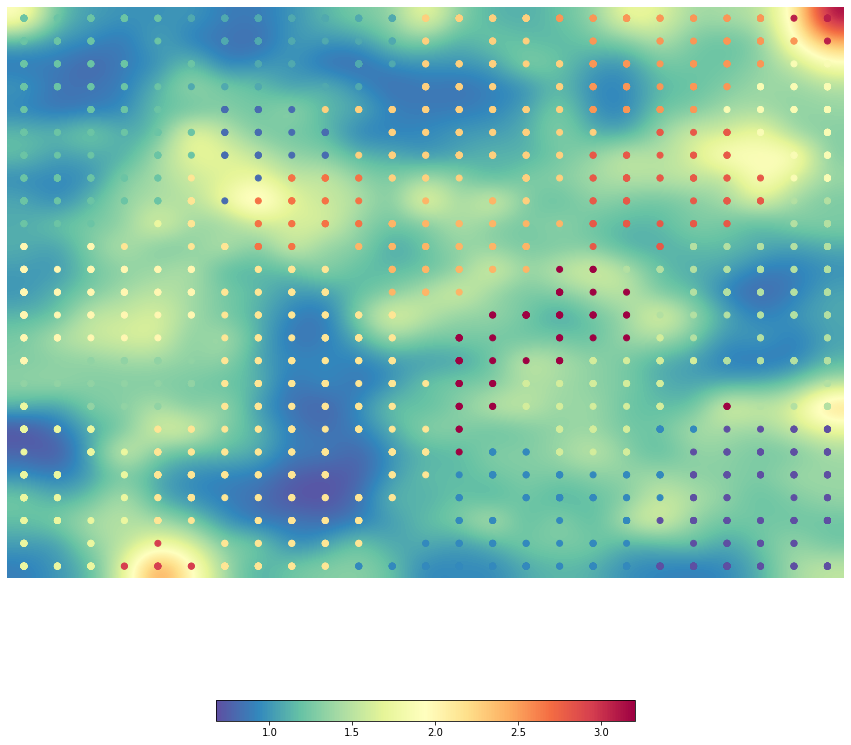

[[ 4  4  4  4  4  3  3  3  3  3  3  3 12 12 12 12 14 14 14 14 14 14 14 18
  18]
 [ 4  4  4  4  4  3  3  3  3  3  3  3 12 12 12 12 14 14 14 14 14 14 14 14
  18]
 [ 4  4  4  4  4  4  3  3  3  3  3  3 12 12 12 12 12 14 14 14 14 14 14  9
   9]
 [ 4  4  4  4  4  3  3  3  3  3  3 12 12 12 12 12 12 14 14 14 14 14  9  9
   9]
 [ 4  4  4  4  4  4  1  1  1 12 12 12 12 12 12 12 12 14 14 14 14  9  9  9
   9]
 [ 4  4  4  4  4  4  1  1  1  1 12 12 12 12 12 12 12 12 14 16 16 16  9  9
   9]
 [ 4  4  4  4  4  4  1  1  1  1 12 12 12 12 12 12 12 16 16 16 16 16  9  9
   9]
 [ 4  4  4  4  4 11  1  1 15 15 15 12 12 12 12 12 12 16 16 16 16 16 16  9
   9]
 [ 4  4  4  4  4 11  1 15 15 15 15 13 13 13 13 12 12 16 16 16 16 16 16  6
   6]
 [ 4  4  4  4  8 11 11 15 15 15 15 13 13 13 13 13 13 16 16 16 16 16  6  6
   6]
 [10 10 10 11 11 11 11 15 15 15 13 13 13 13 13 13 13 16 16 16  6  6  6  6
   6]
 [10 10 10 10 10 10 11 11 11 11 13 13 13 13 13 13 19 19  6  6  6  6  6  6
   6]
 [10 10 10 10 10 10 11 11 11 11 11 13 13

In [ ]:
som.view_umatrix(bestmatches=True, colorbar=True, figsize=(15,15))
print(som.clusters)
_ , no_of_neurons = np.unique(som.clusters, return_counts=True)
cluster_index = np.argsort(no_of_neurons)
print("Cluster Index:")
print(cluster_index)
print("Number of Neurons:")
print(no_of_neurons[cluster_index])

#### k=25

In [ ]:
n_cluster = 25
algorithm = KMeans(n_clusters=n_cluster)
som.cluster(algorithm=algorithm)

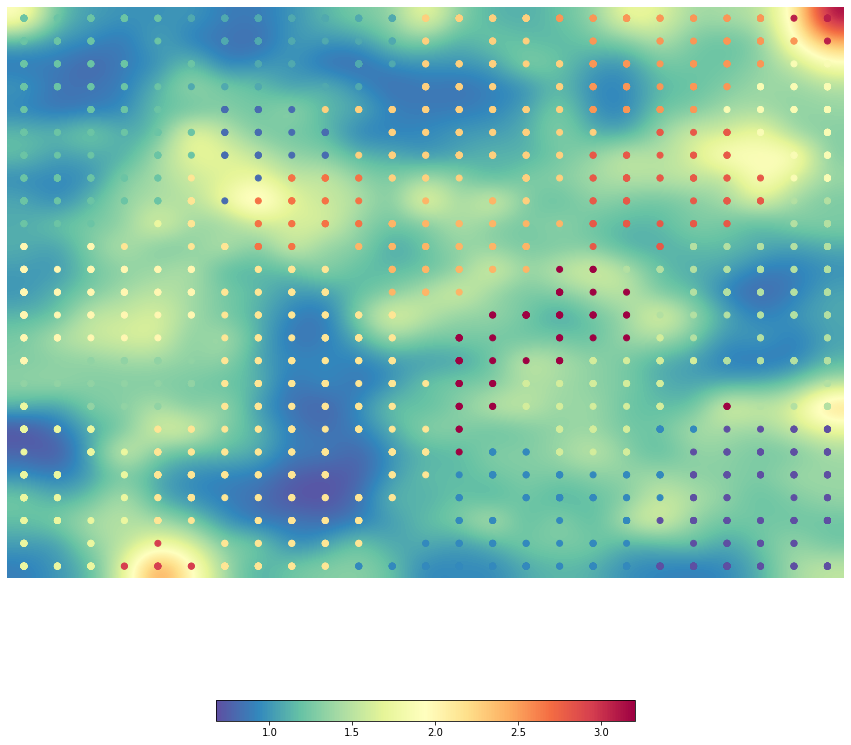

[[ 4  4  4  4  4  3  3  3  3  3  3  3 12 12 12 12 14 14 14 14 14 14 14 18
  18]
 [ 4  4  4  4  4  3  3  3  3  3  3  3 12 12 12 12 14 14 14 14 14 14 14 14
  18]
 [ 4  4  4  4  4  4  3  3  3  3  3  3 12 12 12 12 12 14 14 14 14 14 14  9
   9]
 [ 4  4  4  4  4  3  3  3  3  3  3 12 12 12 12 12 12 14 14 14 14 14  9  9
   9]
 [ 4  4  4  4  4  4  1  1  1 12 12 12 12 12 12 12 12 14 14 14 14  9  9  9
   9]
 [ 4  4  4  4  4  4  1  1  1  1 12 12 12 12 12 12 12 12 14 16 16 16  9  9
   9]
 [ 4  4  4  4  4  4  1  1  1  1 12 12 12 12 12 12 12 16 16 16 16 16  9  9
   9]
 [ 4  4  4  4  4 11  1  1 15 15 15 12 12 12 12 12 12 16 16 16 16 16 16  9
   9]
 [ 4  4  4  4  4 11  1 15 15 15 15 13 13 13 13 12 12 16 16 16 16 16 16  6
   6]
 [ 4  4  4  4  8 11 11 15 15 15 15 13 13 13 13 13 13 16 16 16 16 16  6  6
   6]
 [10 10 10 11 11 11 11 15 15 15 13 13 13 13 13 13 13 16 16 16  6  6  6  6
   6]
 [10 10 10 10 10 10 11 11 11 11 13 13 13 13 13 13 19 19  6  6  6  6  6  6
   6]
 [10 10 10 10 10 10 11 11 11 11 11 13 13

In [ ]:
som.view_umatrix(bestmatches=True, colorbar=True, figsize=(15,15))
print(som.clusters)
_ , no_of_neurons = np.unique(som.clusters, return_counts=True)
cluster_index = np.argsort(no_of_neurons)
print("Cluster Index:")
print(cluster_index)
print("Number of Neurons:")
print(no_of_neurons[cluster_index])

#### k=30

In [ ]:
n_cluster = 30
algorithm = KMeans(n_clusters=n_cluster)
som.cluster(algorithm=algorithm)

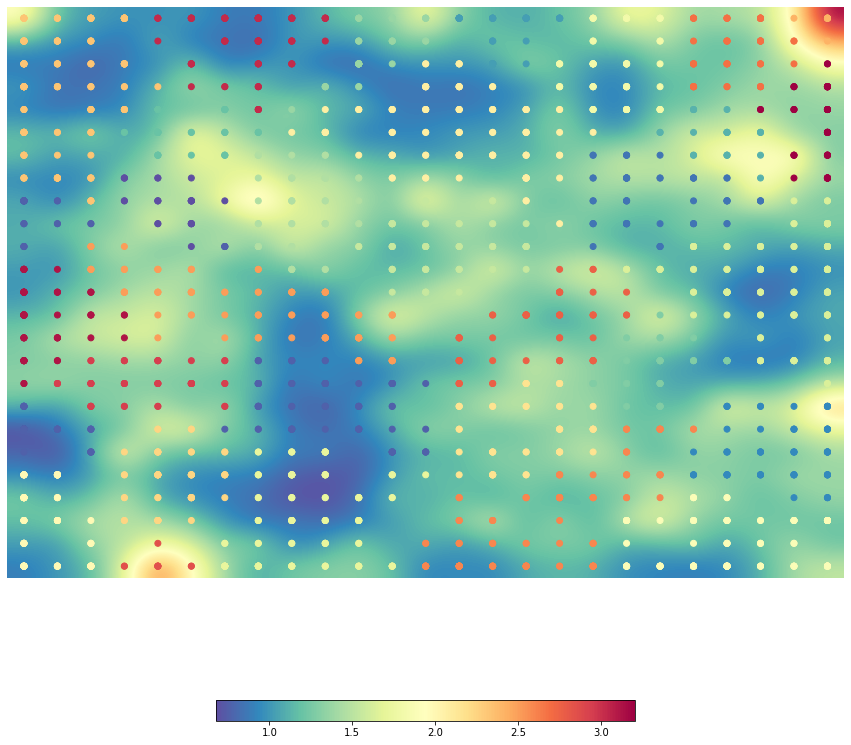

[[19 19 19 19 27 27 27 27 27 27  8  8  8  4  4  4  4 13 13 13 23 23 23 20
  20]
 [19 19 19 19 27 27 27 27 27 27  8  8  8  4  4  4  4 13 13 13 23 23 23 23
  20]
 [19 19 19 19 19 27 27 27 27  8  8  8 16 16  4  4 13 13 13 13 23 23 23 23
  29]
 [19 19 19 19 19 27 27 27 27  8  8 16 16 16 16 16 13 13 13 13 23 23 23 29
  29]
 [19 19 19 19  6  6  6 27  8 16 16 16 16 16 16 16 16 13 13 13  5  5 29 29
  29]
 [19 19 19  6  6  6  6  6 16 16 16 16 16 16 16 16 16 16 13  5  5  5  5 29
  29]
 [19 19 19  6  6  6  6  9  9  9 16 16 16 16 16 16 16  2  2  2  5  5  5 29
  29]
 [19 19 19  0  0  0  0  9  9  9  9 16 16 16 16 16 16  2  2  2  2  2  5 29
  29]
 [ 1  1 19  0  0  0  0  9  9  9  9 10 10 10 10 16 16  2  2  2  2  2  2 11
  11]
 [ 1  1  1  0  0  0  0  9  9  9  9 10 10 10 10 10 16  2  2  2  2  2 11 11
  11]
 [ 1  1 21 21 21  0  1  9  9  9 10 10 10 10 10 10 10  2  2  2 11 11 11 11
  11]
 [28 28 21 21 21 21 21 21  9  9 10 10 10 10 10 10 24 24 11 11 11 11 11 11
  11]
 [28 28 28 21 21 21 21 21 21 21 21 10 10

In [ ]:
som.view_umatrix(bestmatches=True, colorbar=True, figsize=(15,15))
print(som.clusters)
_ , no_of_neurons = np.unique(som.clusters, return_counts=True)
cluster_index = np.argsort(no_of_neurons)
print("Cluster Index:")
print(cluster_index)
print("Number of Neurons:")
print(no_of_neurons[cluster_index])

#### k=35

Πιο αντιπροσωπευτικά αποτελέσματα φάνηκε να δίνει η εκτέλεση του k-means με k=35, καθώς ήταν σαφέστερος ο διαχωρισμός των clusters και των μεταξύ τους ορίων, όπως επίσης οι νευρώνες φάνηκαν να ακολουθούν σε μεγαλύτερο βαθμό από ό,τι προηγουμένως τα clusters του χάρτη.

In [ ]:
n_cluster = 35
algorithm = KMeans(n_clusters=n_cluster)
som.cluster(algorithm=algorithm)

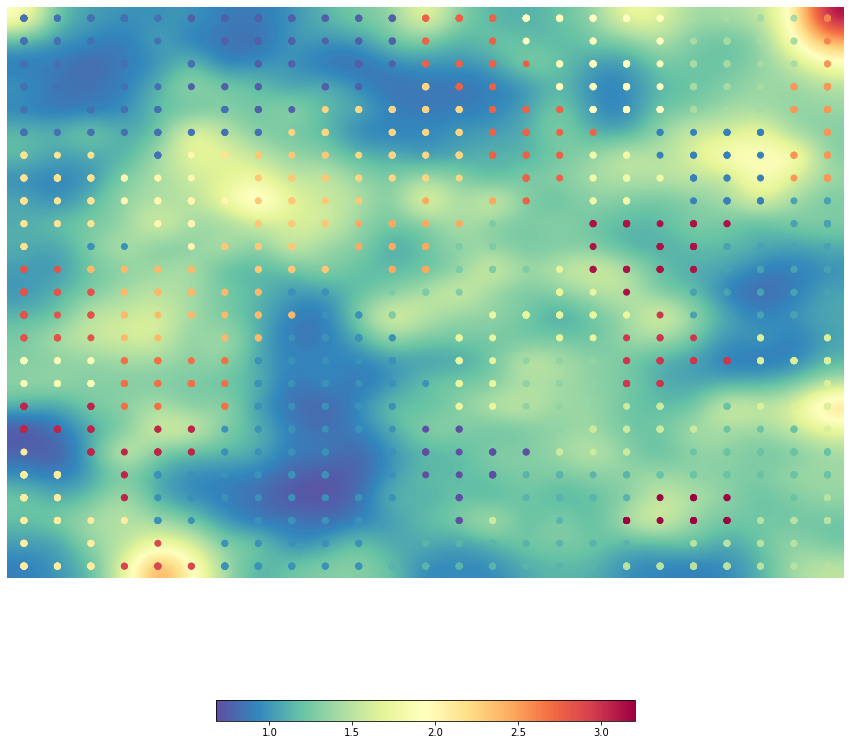

[[ 2  2  2  2  2  1  1  1  1  1  1  1 28 28 28 17 17 17 17 17 10 10 10 10
  26]
 [ 2  2  2  2  2  1  1  1  1  1  1  1 28 28 28 17 17 17 17 17 10 10 10 10
  26]
 [ 2  2  2  2  2  2  1  1  1  1  1  1 28 28 28 28 17 17 17 17 10 10 10 10
  25]
 [ 2  2  2  2  2  1  1  1  1  1  1 21 21 28 28 28 17 17 17 17 10 10 10 25
  25]
 [ 2  2  2  2  2  2  2  1  1 21 21 21 21 21 28 28 28 17 17 17 10 10 10 25
  25]
 [ 2  2  2  2  2  2  2  2 21 21 21 21 21 21 28 28 28 28 17  3  3  3  3 25
  25]
 [20 20 20  2  2 18 20 22 22 22 21 21 21 21 28 28 28 15 15  3  3  3  3 25
  25]
 [20 20 20 18 18 18 18 22 22 22 21 21 21 21 28 28 28 15 15 15  3  3  3 25
  25]
 [20 20 20 18 18 18 18 22 22 22 22 24 24 24 24 28 28 15 15 15  3  3  3  5
   5]
 [20 20 20 18 18 18 18 22 22 22 24 24 24 24  8  8  8 33 33 33 33 33  5  5
   5]
 [20 20  4  4 23 18 22 22 22 22 24 24 24  8  8  8  8 33 33 33 33  5  5  5
   5]
 [29 29 23 23 23 23 23 22 22 22 24 24 24  8  8  8 14 33 33 33 33  5  5  5
   5]
 [29 29 29 23 23 23 23 23  4  4  4  8  8

In [ ]:
som.view_umatrix(bestmatches=True, colorbar=True, figsize=(15,15))
print(som.clusters)
_ , no_of_neurons = np.unique(som.clusters, return_counts=True)
cluster_index = np.argsort(no_of_neurons)
print("Cluster Index:")
print(cluster_index)
print("Number of Neurons:")
print(no_of_neurons[cluster_index])

Παρατηρούμε πως στον χάρτη εμφανίζονται κυρίως μπλε και πράσινες περιοχές, με μερικές κίτρινες και πολύ λίγες θερμότερες. Οι μπλε περιοχές είναι ως επί το πλείστον σαφώς διαχωρισμένες, άρα υπάρχουν ευδιάκριτα clusters στον χάρτη. Ωστόσο η απουσία κόκκινων ορίων υποδεικνύει πως, δεν υπάρχουν όρια, όπου οι νευρώνες να είναι μακριά.


## Σημασιολογική ερμηνεία των clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης του tf-idf, των εμφυτευμάτων και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. 

Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες κινηματογραφικού είδους στο cluster.

Μπορείτε να υλοποιήσετε τη συνάρτηση αυτή όπως θέλετε. Μια πιθανή διαδικασία θα μπορούσε να είναι η ακόλουθη:

1. Ορίζουμε συνάρτηση `print_categories_stats` που δέχεται ως είσοδο λίστα με ids ταινιών. Δημιουργούμε μια κενή λίστα συνολικών κατηγοριών. Στη συνέχεια, για κάθε ταινία επεξεργαζόμαστε το string `categories` ως εξής: δημιουργούμε μια λίστα διαχωρίζοντας το string κατάλληλα με την `split` και αφαιρούμε τα whitespaces μεταξύ ετικετών με την `strip`. Προσθέτουμε τη λίστα αυτή στη συνολική λίστα κατηγοριών με την `extend`. Τέλος χρησιμοποιούμε πάλι την `np.unique` για να μετρήσουμε συχνότητα μοναδικών ετικετών κατηγοριών και ταξινομούμε με την `np.argsort`. Τυπώνουμε τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα. Χρήσιμες μπορεί να σας φανούν και οι `np.ravel`, `np.nditer`, `np.array2string` και `zip`.

2. Ορίζουμε τη βασική μας συνάρτηση `print_cluster_neurons_movies_report` που δέχεται ως όρισμα τον αριθμό ενός cluster. Με τη χρήση της `np.where` μπορούμε να βρούμε τις συντεταγμένες των bmus που αντιστοιχούν στο cluster και με την `column_stack` να φτιάξουμε έναν πίνακα bmus για το cluster. Προσοχή στη σειρά (στήλη - σειρά) στον πίνακα bmus. Για κάθε bmu αυτού του πίνακα ελέγχουμε αν υπάρχει στον πίνακα μοναδικών bmus που έχουμε υπολογίσει στην αρχή συνολικά και αν ναι προσθέτουμε το αντίστοιχο index του νευρώνα σε μια λίστα. Χρήσιμες μπορεί να είναι και οι `np.rollaxis`, `np.append`, `np.asscalar`. Επίσης πιθανώς να πρέπει να υλοποιήσετε ένα κριτήριο ομοιότητας μεταξύ ενός bmu και ενός μοναδικού bmu από τον αρχικό πίνακα bmus.

3. Υλοποιούμε μια βοηθητική συνάρτηση `neuron_movies_report`. Λαμβάνει ένα σύνολο νευρώνων από την `print_cluster_neurons_movies_report` και μέσω της `indices` φτιάχνει μια λίστα με το σύνολο ταινιών που ανήκουν σε αυτούς τους νευρώνες. Στο τέλος καλεί με αυτή τη λίστα την `print_categories_stats` που τυπώνει τις στατιστικές των κατηγοριών.

Μπορείτε βέβαια να προσθέσετε οποιαδήποτε επιπλέον έξοδο σας βοηθάει. Μια χρήσιμη έξοδος είναι πόσοι νευρώνες ανήκουν στο cluster και σε πόσους και ποιους από αυτούς έχουν ανατεθεί ταινίες.

Θα επιτελούμε τη σημασιολογική ερμηνεία του χάρτη καλώντας την `print_cluster_neurons_movies_report` με τον αριθμός ενός cluster που μας ενδιαφέρει. 

Παράδειγμα εξόδου για ένα cluster (μη βελτιστοποιημένος χάρτης, ωστόσο βλέπετε ότι οι μεγάλες κατηγορίες έχουν σημασιολογική  συνάφεια):

```
Overall Cluster Genres stats:  
[('"Horror"', 86), ('"Science Fiction"', 24), ('"B-movie"', 16), ('"Monster movie"', 10), ('"Creature Film"', 10), ('"Indie"', 9), ('"Zombie Film"', 9), ('"Slasher"', 8), ('"World cinema"', 8), ('"Sci-Fi Horror"', 7), ('"Natural horror films"', 6), ('"Supernatural"', 6), ('"Thriller"', 6), ('"Cult"', 5), ('"Black-and-white"', 5), ('"Japanese Movies"', 4), ('"Short Film"', 3), ('"Drama"', 3), ('"Psychological thriller"', 3), ('"Crime Fiction"', 3), ('"Monster"', 3), ('"Comedy"', 2), ('"Western"', 2), ('"Horror Comedy"', 2), ('"Archaeology"', 2), ('"Alien Film"', 2), ('"Teen"', 2), ('"Mystery"', 2), ('"Adventure"', 2), ('"Comedy film"', 2), ('"Combat Films"', 1), ('"Chinese Movies"', 1), ('"Action/Adventure"', 1), ('"Gothic Film"', 1), ('"Costume drama"', 1), ('"Disaster"', 1), ('"Docudrama"', 1), ('"Film adaptation"', 1), ('"Film noir"', 1), ('"Parody"', 1), ('"Period piece"', 1), ('"Action"', 1)]```
   

In [ ]:
from collections import Counter
import operator

def print_categories_stats(movie_list):
    
    total_categories = []
    
    for movie in movie_list:
    
        categ = categories[movie][0]
        categ = categ.split(',')

        for category in categ:
            category = category.strip(' ')
            cacategoryt = category.strip('"')
            total_categories.append(category)
    

    uniq = list(Counter(total_categories).keys())
    indic = list(Counter(total_categories).values())

    
    totals = []
    for i in range(len(uniq)):
        totals.append((uniq[i], indic[i]))
    print(len(totals), "Categories")

    totals.sort(key = operator.itemgetter(1), reverse=True)
    print(totals)
    return 0

Πραγματοποιούμε δοκιμή της συνάρτησης με όλα τα IDs του dataset και προκύπτει πως έχουμε 267 κατηγορίες. Βλέπουμε σε πόσες ταινίες αντιστοιχεί κάθε κατηγορία.

In [ ]:
movie_list_ids = list(range(5000))
print_categories_stats(movie_list_ids)

267 Categories
[('"Drama"', 2263), ('"Comedy"', 1208), ('"Thriller"', 753), ('"Romance Film"', 748), ('"Action"', 723), ('"World cinema"', 583), ('"Crime Fiction"', 552), ('"Horror"', 499), ('"Black-and-white"', 438), ('"Indie"', 424), ('"Adventure"', 410), ('"Short Film"', 406), ('"Family Film"', 404), ('"Action/Adventure"', 401), ('"Science Fiction"', 309), ('"Animation"', 299), ('"Romantic drama"', 287), ('"Mystery"', 286), ('"Musical"', 285), ('"Fantasy"', 253), ('"Romantic comedy"', 239), ('"Comedy film"', 222), ('"War film"', 196), ('"Crime Thriller"', 190), ('"Period piece"', 161), ('"Japanese Movies"', 159), ('"Documentary"', 154), ('"Comedy-drama"', 149), ('"Silent film"', 147), ('"Film adaptation"', 146), ('"Psychological thriller"', 124), ('"Chinese Movies"', 123), ('"Bollywood"', 117), ('"Western"', 115), ('"Children\'s/Family"', 104), ('"Parody"', 96), ('"Coming of age"', 95), ('"Martial Arts Film"', 94), ('"Black comedy"', 91), ('"Family Drama"', 85), ('"Cult"', 82), ('"S

0

Η συνάρτηση print_cluster_neurons_movies_report, δέχεται ως όρισμα τον αριθμό ενός cluster, εντοπίζει τις συντεταγμένες των bmus που αντιστοιχούν στο cluster και επιστρέφει μια λίστα με αριθμούς που αντιστοιχούν στις συντεταγμένες των νευρώνων. Έτσι, μέσω των bmus θα βρόυμε τις ταινίες που θα χρησιμοποιήσουμε σαν όρισμα για την παραπάνω συνάρτηση (print_categories_stats)

In [ ]:
def print_cluster_neurons_movies_report(cluster_id):

    neurons_num = no_of_neurons[cluster_id]
    positions = np.where(som.clusters==cluster_id)
    pos = np.column_stack((positions[0], positions[1]))

    ind = []
    for position in pos:
        if position in ubmus:
            ind.append(int(position[0])*n_rows + int(position[1]))
    return ind

In [ ]:
print_cluster_neurons_movies_report(2)

[0,
 1,
 2,
 3,
 4,
 25,
 26,
 27,
 28,
 29,
 50,
 51,
 52,
 53,
 54,
 55,
 75,
 76,
 77,
 78,
 79,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 153,
 154]

Η βοηθητική συνάρτηση neuron_movies_report, λαμβάνει ένα σύνολο νευρώνων από την print_cluster_neurons_movies_report και μέσω της indices φτιάχνει μια λίστα με το σύνολο ταινιών που ανήκουν σε αυτούς τους νευρώνες.

In [ ]:
def neuron_movies_report(neuron_list):

    movie_list_IDs = []
    for neuron in neuron_list:

        list_of_movies = list(np.where(indices==neuron))

        for i in range(len(list_of_movies[0])):
            movie_list_IDs.append(list_of_movies[0][i])

    print_categories_stats(movie_list_IDs)

Τώρα έχουμε εποπτεία των κατηγοριών που διαμορφώνουν το κάθε cluster, όπως φαίνεται παρακάτω. Παρατηρούμε πως υπάρχουν clusters με 0 κατηγορίες, αλλά ως επί το πλείστον, 

In [ ]:
for i in list(cluster_index):
    print("Cluster ID" , i)
    neuron_movies_report(print_cluster_neurons_movies_report(i))

Cluster ID 26
23 Categories
[('"Romantic drama"', 13), ('"Romance Film"', 13), ('"Drama"', 13), ('"World cinema"', 13), ('"Comedy"', 6), ('"Thriller"', 3), ('"Black-and-white"', 2), ('"Crime Fiction"', 2), ('"Chinese Movies"', 2), ('"Indie"', 1), ('"Crime Thriller"', 1), ('"Adventure"', 1), ('"Costume Adventure"', 1), ('"Period piece"', 1), ('"Marriage Drama"', 1), ('"Psychological thriller"', 1), ('"Fantasy"', 1), ('"Romantic fantasy"', 1), ('"Melodrama"', 1), ('"Tamil cinema"', 1), ('"Family Film"', 1), ('"Animal Picture"', 1), ('"Slapstick"', 1)]
Cluster ID 30
0 Categories
[]
Cluster ID 16
15 Categories
[('"Science Fiction"', 9), ('"Thriller"', 6), ('"Horror"', 4), ('"Animation"', 3), ('"Action"', 2), ('"Heaven-Can-Wait Fantasies"', 1), ('"Experimental film"', 1), ('"Surrealism"', 1), ('"Fantasy"', 1), ('"Avant-garde"', 1), ('"Erotic thriller"', 1), ('"Supernatural"', 1), ('"B-movie"', 1), ('"Comedy"', 1), ('"Black-and-white"', 1)]
Cluster ID 34
35 Categories
[('"Action/Adventure"',


## Tips για το SOM και το clustering

- Για την ομαδοποίηση ένα U-matrix καλό είναι να εμφανίζει και μπλε-πράσινες περιοχές (clusters) και κόκκινες περιοχές (ορίων). Παρατηρήστε ποια σχέση υπάρχει μεταξύ αριθμού ταινιών στο final set, μεγέθους grid και ποιότητας U-matrix.
- Για το k του k-Means προσπαθήστε να προσεγγίζει σχετικά τα clusters του U-matrix (όπως είπαμε είναι διαφορετικοί μέθοδοι clustering). Μικρός αριθμός k δεν θα σέβεται τα όρια. Μεγάλος αριθμός θα δημιουργεί υπο-clusters εντός των clusters που φαίνονται στο U-matrix. Το τελευταίο δεν είναι απαραίτητα κακό, αλλά μεγαλώνει τον αριθμό clusters που πρέπει να αναλυθούν σημασιολογικά.
- Σε μικρούς χάρτες και με μικρά final sets δοκιμάστε διαφορετικές παραμέτρους για την εκπαίδευση του SOM. Σημειώστε τυχόν παραμέτρους που επηρεάζουν την ποιότητα του clustering για το dataset σας ώστε να τις εφαρμόσετε στους μεγάλους χάρτες.
- Κάποια τοπολογικά χαρακτηριστικά εμφανίζονται ήδη σε μικρούς χάρτες. Κάποια άλλα χρειάζονται μεγαλύτερους χάρτες. Δοκιμάστε μεγέθη 20x20, 25x25 ή και 30x30 και αντίστοιχη προσαρμογή των k. Όσο μεγαλώνουν οι χάρτες, μεγαλώνει η ανάλυση του χάρτη αλλά μεγαλώνει και ο αριθμός clusters που πρέπει να αναλυθούν.




## Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM

Μετά το πέρας της εκπαίδευσης και του clustering θα έχετε ένα χάρτη με τοπολογικές ιδιότητες ως προς τα είδη των ταίνιών της συλλογής σας, κάτι αντίστοιχο με την εικόνα στην αρχή της Εφαρμογής 2 αυτού του notebook. Η συγκεκριμένη εικόνα είναι μόνο για εικονογράφιση, δεν είναι χάρτης SOM καιδεν έχει καμία σχέση με τη συλλογή δεδομένων και τις κατηγορίες μας.

Για τον τελικό χάρτη SOM που θα παράξετε για τη συλλογή σας, αναλύστε σε markdown με συγκεκριμένη αναφορά σε αριθμούς clusters και τη σημασιολογική ερμηνεία τους τις εξής τρεις τοπολογικές ιδιότητες του SOM: 

1. Δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Δώστε παραδείγματα από συχνές και λιγότερο συχνές κατηγορίες ταινιών. Χρησιμοποιήστε τις στατιστικές των κατηγοριών στη συλλογή σας και τον αριθμό κόμβων που χαρακτηρίζουν.
2. Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη.
3. Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. Σε μεγάλους χάρτες εντοπίστε είδη ταινιών και κοντινά τους υποείδη.

Προφανώς τοποθέτηση σε 2 διαστάσεις που να σέβεται μια απόλυτη τοπολογία δεν είναι εφικτή, αφενός γιατί δεν υπάρχει κάποια απόλυτη εξ ορισμού για τα κινηματογραφικά είδη ακόμα και σε πολλές διαστάσεις, αφετέρου γιατί πραγματοποιούμε μείωση διαστατικότητας.

Εντοπίστε μεγάλα clusters και μικρά clusters που δεν έχουν σαφή χαρακτηριστικά. Εντοπίστε clusters συγκεκριμένων ειδών που μοιάζουν να μην έχουν τοπολογική συνάφεια με γύρω περιοχές. Προτείνετε πιθανές ερμηνείες.


Τέλος, εντοπίστε clusters που έχουν κατά την άποψή σας ιδιαίτερο ενδιαφέρον στη συλλογή της ομάδας σας (data exploration / discovery value) και σχολιάστε.


### Δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Δώστε παραδείγματα από συχνές και λιγότερο συχνές κατηγορίες ταινιών. Χρησιμοποιήστε τις στατιστικές των κατηγοριών στη συλλογή σας και τον αριθμό κόμβων που χαρακτηρίζουν.

In [ ]:
def find_category_in_neurons(category):

    number_of_neurons_found_in = 0
    for neuron in range(n_rows*n_columns):

        list_of_movies = list(np.where(indices==neuron))
        category_list = []
        for i in range(len(list_of_movies[0])):
            categ = categories[list_of_movies[0][i]][0]
            categ = categ.split(',')
        
            for categor in categ:
                categor = categor.strip(' ')
                categor = categor.strip('"')
                category_list.append(categor)

        uniq1 = list(Counter(category_list).keys())
        indices1 = list(Counter(category_list).values())
        if (category in uniq1):
            if (uniq1.index(category) < 5):
                number_of_neurons_found_in += 1

    print("Category '" + category + "', found in " , number_of_neurons_found_in, "neurons.")

In [ ]:
movie_list_ids = list(range(5000))
print_categories_stats(movie_list_ids)

267 Categories
[('"Drama"', 2263), ('"Comedy"', 1208), ('"Thriller"', 753), ('"Romance Film"', 748), ('"Action"', 723), ('"World cinema"', 583), ('"Crime Fiction"', 552), ('"Horror"', 499), ('"Black-and-white"', 438), ('"Indie"', 424), ('"Adventure"', 410), ('"Short Film"', 406), ('"Family Film"', 404), ('"Action/Adventure"', 401), ('"Science Fiction"', 309), ('"Animation"', 299), ('"Romantic drama"', 287), ('"Mystery"', 286), ('"Musical"', 285), ('"Fantasy"', 253), ('"Romantic comedy"', 239), ('"Comedy film"', 222), ('"War film"', 196), ('"Crime Thriller"', 190), ('"Period piece"', 161), ('"Japanese Movies"', 159), ('"Documentary"', 154), ('"Comedy-drama"', 149), ('"Silent film"', 147), ('"Film adaptation"', 146), ('"Psychological thriller"', 124), ('"Chinese Movies"', 123), ('"Bollywood"', 117), ('"Western"', 115), ('"Children\'s/Family"', 104), ('"Parody"', 96), ('"Coming of age"', 95), ('"Martial Arts Film"', 94), ('"Black comedy"', 91), ('"Family Drama"', 85), ('"Cult"', 82), ('"S

0

#### Παραδείγματα από τις πιο συχνές κατηγορίες ταινιών:

In [ ]:
find_category_in_neurons("Drama")
find_category_in_neurons("Comedy")
find_category_in_neurons("Thriller")
find_category_in_neurons("Romance Film")
find_category_in_neurons("Action")
find_category_in_neurons("World cinema")
find_category_in_neurons("Crime Fiction")
find_category_in_neurons("Horror")
find_category_in_neurons("Black-and-white")
find_category_in_neurons("Indie")

Category 'Drama', found in  244 neurons.
Category 'Comedy', found in  114 neurons.
Category 'Thriller', found in  100 neurons.
Category 'Romance Film', found in  54 neurons.
Category 'Action', found in  57 neurons.
Category 'World cinema', found in  73 neurons.
Category 'Crime Fiction', found in  70 neurons.
Category 'Horror', found in  57 neurons.
Category 'Black-and-white', found in  57 neurons.
Category 'Indie', found in  54 neurons.


#### Παραδείγματα από λιγότερο συχνές κατηγορίες ταινιών:

In [ ]:
find_category_in_neurons("Animation")
find_category_in_neurons("Japanese Movies")
find_category_in_neurons("Western")
find_category_in_neurons("Mockumentary")

Category 'Animation', found in  40 neurons.
Category 'Japanese Movies', found in  28 neurons.
Category 'Western', found in  20 neurons.
Category 'Mockumentary', found in  4 neurons.


#### Παραδείγματα από σχεδόν καθόλου συχνές κατηγορίες ταινιών:

In [ ]:
find_category_in_neurons("Dance")
find_category_in_neurons("Alien Film")
find_category_in_neurons("Fictional film")
find_category_in_neurons("Tragicomedy")

Category 'Dance', found in  3 neurons.
Category 'Alien Film', found in  2 neurons.
Category 'Fictional film', found in  1 neurons.
Category 'Tragicomedy', found in  0 neurons.


Παρατηρούμε πως οι κατηγορίες που εμφανίζονται συχνότερα, εμφανιζονται και σε περισσοτερους νευρωνες, ενώ αντίστοιχα όσο λιγότερο συχνή είναι μια κατηγορια, τόσο λιγότερο συχνή είναι στους νευρώνες.

### Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη.

In [ ]:
def distant_categories(category1, category2):

    neurons_found_in1 = []
    neurons_found_in2 = []

    for neuron in range(n_rows*n_columns):

        list_of_movies = list(np.where(indices==neuron))
        category_list = []
        for i in range(len(list_of_movies[0])):
            cats1 = categories[list_of_movies[0][i]][0]
            cats1 = cats1.split(',')
        
            for cat1 in cats1:
                cat1 = cat1.strip(' ')
                cat1 = cat1.strip('"')
                category_list.append(cat1)

        uniq1 = list(Counter(category_list).keys())
        indices1 = list(Counter(category_list).values())
        if (category1 in uniq1):
            if (uniq1.index(category1) < 5):
                l = list(ubmus[neuron])
                neurons_found_in1.append((l[0], l[1]))
        if (category2 in uniq1):
            if (uniq1.index(category2) < 5):
                l = list(ubmus[neuron])
                neurons_found_in2.append((l[0], l[1]))
    
    
    print("Category '" + category1 + "', found in ", len(neurons_found_in1), " neurons:" , neurons_found_in1)
    print()

    print("Category '" + category2 + "', found in ", len(neurons_found_in2), " neurons:" , neurons_found_in2)
    print()

    intersect = list(set(neurons_found_in1).intersection(neurons_found_in2))

    print("Both categories are found in ", len(intersect), " neurons:" , intersect)

Παρακάτω δίνεται ένα παράδειγμα δύο κατηγοριών που θα έπρεπε να αντιστοιχούν σε πολύ απομακρυσμένα μεταξύ τους σημεία στον χάρτη. Αυτό επιβεβαιώνεται και από τις θέσεις στον χάρτη, καθώς και από το γεγονός ότι οι δύο αυτές κατηγορίες υπάρχουν από κοινού μόνο σε έναν νευρώνα.

In [ ]:
distant_categories("Bollywood", "Animation")

Category 'Bollywood', found in  17  neurons: [(3, 2), (4, 21), (4, 22), (4, 23), (5, 24), (6, 3), (8, 7), (9, 5), (11, 4), (12, 2), (12, 3), (13, 2), (13, 3), (13, 22), (15, 13), (18, 24), (20, 18)]

Category 'Animation', found in  40  neurons: [(0, 6), (2, 8), (10, 7), (10, 23), (11, 4), (12, 4), (13, 6), (16, 4), (17, 7), (17, 8), (18, 6), (18, 7), (19, 4), (20, 0), (20, 1), (20, 2), (20, 3), (20, 4), (20, 5), (20, 13), (21, 0), (21, 1), (21, 2), (21, 3), (21, 4), (21, 5), (21, 24), (22, 0), (22, 1), (22, 2), (22, 3), (22, 4), (22, 5), (23, 0), (23, 1), (23, 2), (23, 3), (23, 4), (24, 0), (24, 2)]

Both categories are found in  1  neurons: [(11, 4)]


### Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. Σε μεγάλους χάρτες εντοπίστε είδη ταινιών και κοντινά τους υποείδη.

Παρακάτω δίνονται τρία παραδείγματα με κατηγορίες ταινιών που σημασιολογικά βρίσκονται κοντά και από τα αποτελέσματα πράγματι επιβεβαιώνεται πως βρίσκονται σε αρκετούς κοινούς νευρώνες.

In [ ]:
distant_categories("Thriller", "Crime Thriller")

Category 'Thriller', found in  100  neurons: [(0, 4), (0, 12), (2, 13), (6, 3), (10, 0), (10, 2), (13, 14), (13, 15), (13, 16), (13, 17), (13, 18), (13, 19), (14, 13), (14, 14), (14, 15), (14, 16), (14, 17), (14, 19), (14, 20), (15, 13), (15, 15), (15, 16), (15, 17), (15, 19), (15, 20), (15, 21), (16, 12), (16, 13), (16, 14), (16, 15), (16, 16), (16, 17), (16, 18), (16, 19), (16, 20), (16, 21), (16, 22), (17, 11), (17, 13), (17, 14), (17, 15), (17, 16), (17, 17), (17, 18), (17, 19), (17, 20), (17, 21), (18, 9), (18, 11), (18, 12), (18, 13), (18, 14), (18, 15), (18, 16), (18, 17), (18, 18), (18, 19), (18, 20), (18, 21), (18, 23), (19, 13), (19, 14), (19, 15), (19, 16), (19, 17), (19, 18), (19, 20), (19, 21), (19, 22), (20, 15), (20, 18), (20, 19), (20, 20), (21, 6), (21, 15), (21, 17), (21, 18), (21, 19), (21, 20), (22, 14), (22, 15), (22, 17), (22, 18), (22, 19), (22, 20), (23, 15), (23, 17), (23, 18), (23, 19), (23, 20), (23, 21), (24, 9), (24, 14), (24, 15), (24, 16), (24, 17), (24, 

In [ ]:
distant_categories("Romance Film", "Romantic drama")

Category 'Romance Film', found in  54  neurons: [(0, 17), (0, 18), (0, 19), (0, 20), (0, 24), (1, 9), (1, 16), (1, 18), (1, 21), (1, 24), (2, 18), (2, 19), (2, 24), (3, 17), (3, 20), (3, 21), (3, 24), (4, 0), (4, 18), (5, 3), (5, 9), (6, 0), (6, 1), (6, 3), (6, 24), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (8, 0), (8, 1), (8, 2), (8, 4), (9, 0), (9, 1), (9, 3), (9, 7), (9, 9), (9, 24), (10, 0), (10, 1), (10, 2), (10, 3), (10, 24), (11, 0), (11, 1), (11, 2), (11, 24), (12, 0), (12, 24), (17, 2), (21, 1), (23, 7)]

Category 'Romantic drama', found in  17  neurons: [(0, 20), (0, 23), (0, 24), (1, 20), (1, 21), (1, 22), (1, 24), (2, 17), (2, 23), (2, 24), (3, 24), (4, 18), (4, 24), (7, 5), (9, 20), (9, 22), (10, 17)]

Both categories are found in  7  neurons: [(3, 24), (1, 21), (1, 24), (0, 20), (4, 18), (0, 24), (2, 24)]


In [ ]:
distant_categories("Science Fiction", "Fantasy")

Category 'Science Fiction', found in  46  neurons: [(0, 4), (2, 3), (2, 19), (3, 19), (9, 12), (14, 16), (15, 15), (16, 5), (16, 15), (17, 7), (17, 9), (17, 10), (17, 11), (18, 4), (18, 7), (18, 8), (18, 9), (18, 11), (18, 12), (19, 4), (19, 7), (19, 9), (19, 10), (19, 11), (19, 13), (20, 7), (20, 8), (20, 9), (20, 10), (20, 11), (20, 24), (21, 7), (21, 8), (21, 9), (21, 15), (22, 5), (22, 8), (22, 17), (23, 0), (23, 6), (23, 17), (24, 3), (24, 6), (24, 18), (24, 19), (24, 20)]

Category 'Fantasy', found in  39  neurons: [(0, 3), (0, 5), (0, 7), (0, 20), (2, 3), (5, 3), (6, 16), (7, 0), (7, 1), (7, 2), (7, 3), (7, 16), (8, 13), (8, 17), (8, 18), (11, 1), (13, 2), (13, 6), (14, 8), (15, 8), (16, 21), (17, 2), (17, 9), (20, 3), (21, 4), (21, 8), (21, 9), (22, 1), (22, 2), (22, 3), (22, 4), (22, 5), (23, 1), (23, 4), (23, 7), (23, 13), (23, 15), (24, 3), (24, 5)]

Both categories are found in  6  neurons: [(17, 9), (22, 5), (21, 8), (21, 9), (24, 3), (2, 3)]


### Παράδειγμα μεγάλου cluster που δεν έχει σαφή χαρακτηριστικά:


In [ ]:
neuron_movies_report(print_cluster_neurons_movies_report(1))

86 Categories
[('"Drama"', 91), ('"Comedy"', 56), ('"Adventure"', 27), ('"World cinema"', 20), ('"Comedy-drama"', 17), ('"Action/Adventure"', 16), ('"Indie"', 15), ('"Romance Film"', 14), ('"Film adaptation"', 12), ('"Family Film"', 11), ('"War film"', 11), ('"Musical"', 9), ('"Bollywood"', 9), ('"Period piece"', 8), ('"Fantasy"', 7), ('"Black comedy"', 7), ('"Science Fiction"', 6), ('"Parody"', 5), ('"Road movie"', 5), ('"Coming of age"', 5), ('"Family Drama"', 5), ('"Action"', 5), ('"Short Film"', 4), ('"Japanese Movies"', 4), ('"Satire"', 4), ('"Melodrama"', 4), ('"Western"', 4), ('"History"', 4), ('"Children\'s/Family"', 3), ('"Thriller"', 3), ('"Teen"', 3), ('"Cult"', 3), ('"Black-and-white"', 3), ('"Historical fiction"', 3), ('"Epic"', 3), ('"Adventure Comedy"', 2), ('"Time travel"', 2), ('"Fantasy Comedy"', 2), ('"Juvenile Delinquency Film"', 2), ('"Dystopia"', 2), ('"Experimental film"', 2), ('"Avant-garde"', 2), ('"Ensemble Film"', 2), ('"Domestic Comedy"', 2), ('"Biopic [feat

Στο συγκεκριμένο παράδειγμα, πολλές από τις κατηγορίες δεν φαίνεται να έχουν κάποια συνάφεια μεταξύ τους, επομένως δεν υπάρχουν σαφή χαρακτηριστικά στο συγκεκριμένο cluster.

### Παράδειγμα μικρότερου cluster που δεν έχει σαφή χαρακτηριστικά:

In [ ]:
neuron_movies_report(print_cluster_neurons_movies_report(8))

32 Categories
[('"Drama"', 18), ('"Comedy film"', 12), ('"Documentary"', 9), ('"Crime Fiction"', 8), ('"Thriller"', 8), ('"World cinema"', 8), ('"Musical"', 6), ('"Bollywood"', 5), ('"Family Film"', 3), ('"Silent film"', 2), ('"Short Film"', 2), ('"Animation"', 2), ('"Romance Film"', 2), ('"Action"', 2), ('"Fantasy"', 2), ('"Family Drama"', 1), ('"New Hollywood"', 1), ('"Remake"', 1), ('"Marriage Drama"', 1), ('"Courtroom Drama"', 1), ('"Crime Drama"', 1), ('"Mystery"', 1), ('"Japanese Movies"', 1), ('"Comedy-drama"', 1), ('"Filipino Movies"', 1), ('"Adventure"', 1), ('"Culture & Society"', 1), ('"Time travel"', 1), ('"Experimental film"', 1), ('"Punk rock"', 1), ('"Indie"', 1), ('"Crime Thriller"', 1)]


Αντίστοιχα, σε αυτό το λίγο μικρότερο cluster, επίσης δεν υπάρχουν σαφή χαρακτηριστικά, καθώς οι κατηγορίες δεν δείχνουν να σχετίζονται.

### Παράδειγμα clusters συγκεκριμένων ειδών που μοιάζουν να μην έχουν τοπολογική συνάφεια με γύρω περιοχές:

Παρακάτω δίνεται ένα παράδειγμα νευρώνων που βρίσκονται σε κοντινή περιοχή μεταξύ τους, χωρίς να παρουσιάζουν συνάφεια στις κατηγορίες. 

Cluster ID 5\
58 Categories\
[('"Drama"', 34), ('"Crime Fiction"', 27), ('"Black-and-white"', 24), ('"Thriller"', 23), ('"Short Film"', 18), ('"Film noir"', 13), ('"Mystery"', 11), ('"Comedy"', 11), ('"Romance Film"', 8), ('"Documentary"', 8), ('"Silent film"', 7), ('"Indie"', 7), ('"Action"', 4), ('"Detective"', 4), ('"World cinema"', 3), ('"Black comedy"', 3), ('"Family Film"', 3), ('"Melodrama"', 3), ('"Psychological thriller"', 3), ('"Crime Thriller"', 3), ('"Crime Drama"', 3), ('"Detective fiction"', 3), ('"Adventure"', 2), ('"History"', 2), ('"Biographical film"', 2), ('"Romantic comedy"', 2), ('"Comedy film"', 2), ('"Culture & Society"', 2), ('"Social issues"', 2), ('"Suspense"', 2), ('"Spy"', 2), ('"Fantasy"', 1), ('"Chinese Movies"', 1), ('"Art film"', 1), ('"Feminist Film"', 1), ('"Comedy-drama"', 1), ('"Propaganda film"', 1), ('"Language & Literature"', 1), ('"Satire"', 1), ('"Outlaw biker film"', 1), ('"Horror"', 1), ('"Addiction Drama"', 1), ('"Action/Adventure"', 1), ('"Western"', 1), ('"War film"', 1), ('"Ensemble Film"', 1), ('"Musical"', 1), ('"Period piece"', 1), ('"Music"', 1), ('"Heist"', 1), ('"Pre-Code"', 1), ('"Television movie"', 1), ('"Law & Crime"', 1), ('"Political cinema"', 1), ('"Political drama"', 1), ('"Courtroom Drama"', 1), ('"Slapstick"', 1), ('"Animation"', 1)]\
 και

Cluster ID 25\
41 Categories\
[('"Drama"', 30), ('"Family Film"', 10), ('"Adventure"', 9), ('"Family Drama"', 6), ('"Comedy"', 4), ('"Historical fiction"', 4), ('"Sports"', 3), ('"Comedy-drama"', 3), ('"Coming of age"', 3), ('"Biography"', 3), ('"Biopic [feature]"', 3), ('"Period piece"', 3), ('"Costume drama"', 3), ('"Children\'s/Family"', 3), ('"Indie"', 2), ('"Epic"', 2), ('"War film"', 2), ('"World cinema"', 2), ('"History"', 2), ('"Black-and-white"', 2), ('"Family-Oriented Adventure"', 2), ('"Fantasy"', 2), ('"Animal Picture"', 2), ('"Buddy film"', 1), ('"Christian film"', 1), ('"Art film"', 1), ('"Biographical film"', 1), ('"Historical Epic"', 1), ('"Historical drama"', 1), ('"Mystery"', 1), ('"Courtroom Drama"', 1), ('"Television movie"', 1), ('"Docudrama"', 1), ('"Fantasy Adventure"', 1), ('"Children\'s Fantasy"', 1), ('"Teen"', 1), ('"Action"', 1), ('"Short Film"', 1), ('"Feminist Film"', 1), ('"Music"', 1), ('"Melodrama"', 1)]
Cluster ID 27

Παρατηρούμε πως τα clusters 5 και 25 που βρίσκονται στο δεξί σημείο του χάρτη, ενώ είναι κοντά μεταξύ τους, οι κατηγορίες τις οποίες περιλαμβάνουν δεν έχουν μεγάλη σχέση μεταξύ τους. Ειδικότερα, το cluster 5 έχει βασικές κατηγορίες το Crime Fiction και το Thriller, ενώ το cluster 25 έχει ως κύριες κατηγορίες Drama, Family Film, Adventure. 

Τέτοια φαινόμενα οφείλονται στο γεγονός ότι για τόσες διαστάσεις, δεν είναι εφικτή μία τοποθέτηση σε 2 διαστάσεις που να σέβεται μια απόλυτη τοπολογία. Ωστόσο παρατηρώντας τα υπόλοιπα clusters που βρίσκονται κοντά μεταξύ τους, παρατηρήσαμε πως στην πλειοψηφία τους ήταν εννοιολογικά αρκετά συναφή.

### Παράδειγμα cluster με ιδιαίτερο ενδιαφέρον:

In [ ]:
neuron_movies_report(print_cluster_neurons_movies_report(4))

113 Categories
[('"Family Film"', 60), ('"Animation"', 60), ('"Short Film"', 43), ('"Thriller"', 42), ('"Drama"', 41), ('"Action"', 41), ('"Comedy"', 38), ('"Crime Thriller"', 34), ('"Crime Fiction"', 31), ('"Horror"', 31), ('"Adventure"', 31), ('"Fantasy"', 24), ('"Mystery"', 23), ('"Psychological thriller"', 19), ('"Action/Adventure"', 16), ('"Indie"', 14), ('"World cinema"', 12), ('"Documentary"', 11), ('"Suspense"', 11), ('"Comedy film"', 11), ('"Children\'s/Family"', 10), ('"Romance Film"', 10), ('"Science Fiction"', 8), ('"Supernatural"', 8), ('"Black-and-white"', 7), ('"Musical"', 7), ('"Children\'s"', 7), ('"Chinese Movies"', 6), ('"Film adaptation"', 6), ('"Period piece"', 6), ('"Zombie Film"', 6), ('"Japanese Movies"', 5), ('"Costume drama"', 5), ('"Cult"', 5), ('"Western"', 5), ('"Computer Animation"', 5), ('"Children\'s Fantasy"', 5), ('"Black comedy"', 4), ('"Detective"', 4), ('"Comedy-drama"', 4), ('"Horror Comedy"', 4), ('"Animal Picture"', 4), ('"B-movie"', 4), ('"Famil

Παράδειγμα που θεωρήσαμε ότι έχει ιδιαίτερο ενδιαφέρον, είναι το παραπάνω cluster, το οποίο έχει ως βασική κατηγορία το Family Film και βλέπουμε να εμφανίζεται πολύ συχνά και η κατηγορία Thriller. Αυτό πιστεύουμε ότι ο οφείλεται στο γεγονός ότι πολύ συχνά οι ταινίες Thriller έχουν βασικούς πρωταγωνιστές τα μέλη κάποιας οικογένειας.


# Τελική παράδοση άσκησης

- Θα παραδώσετε στο helios το παρόν notebook επεξεργασμένο ή ένα ή δύο νέα zipαρισμένα με τις απαντήσεις σας για τα ζητούμενα και των δύο εφαρμογών. 
- Θυμηθείτε ότι η ανάλυση του χάρτη στο markdown με αναφορά σε αριθμούς clusters πρέπει να αναφέρεται στον τελικό χάρτη με τα κελιά ορατά που θα παραδώσετε αλλιώς ο χάρτης που θα προκύψει θα είναι διαφορετικός και τα labels των clusters δεν θα αντιστοιχούν στην ανάλυσή σας. 
- Μην ξεχάσετε στην αρχή ένα κελί markdown με **τα στοιχεία της ομάδας σας**.

<table>
  <tr><td align="center">
    <font size="4">Παρακαλούμε διατρέξτε βήμα-βήμα το notebook για να μην ξεχάσετε παραδοτέα</font>
</td>
  </tr>
</table>